In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np


In [2]:
size = 300
noise_std = 5e-2
alpha = .2
lr = 1e-3

input_size = 3
output_size = 1


In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(10000)


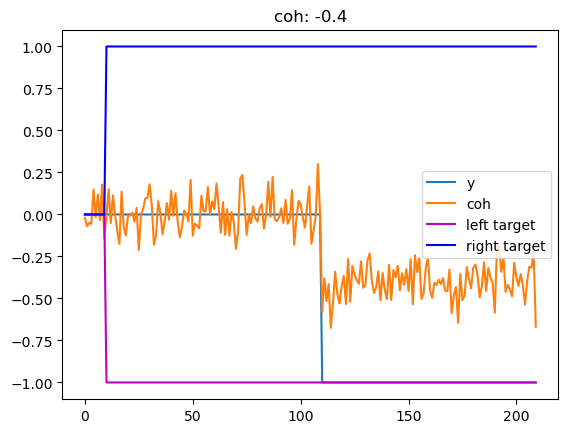

In [4]:
n = 1

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], 'm', label = 'left target')
plt.plot(x_val[n,:,2], 'b', label = 'right target')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()




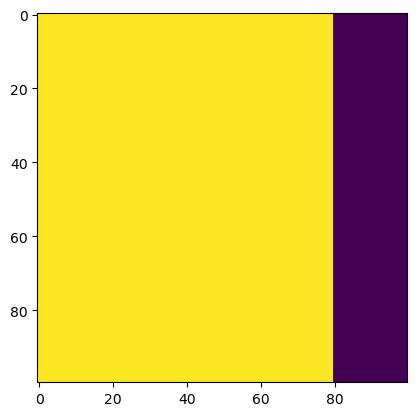

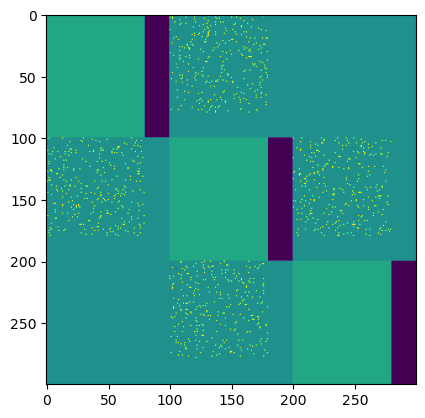

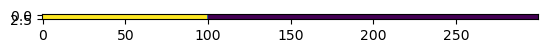

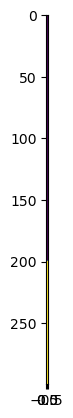

In [5]:
def create_local_conn(Inum, ratio, n_neurons):

    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = -1
    
    mask_rec[:,:n_neurons-Inum] = ratio    

    return mask_rec

plt.imshow(create_local_conn(20,0.2,100))
plt.show()

def create_area_conn(Inum, ratio, n_neurons): 
    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = 0
    mask_rec[n_neurons-Inum:,:] = 0
    
    # Define the size of the matrix
    rows, cols = n_neurons-Inum, n_neurons-Inum
    
    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
    
    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
    
    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
    
    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1
    
    mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

    return mask_rec





n_neurons = 300
n_inputs = 3
n_outputs = 1
training_trials = 5000



mask_rec = torch.zeros(n_neurons, n_neurons)
mask_in = torch.ones(n_inputs, n_neurons)
mask_out = torch.ones(n_neurons, n_outputs)

mask_in[:,100:] = 0
mask_out[:200,:] = 0

mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
mask_rec[:100,100:200] = create_area_conn(20,0.046875,100)
mask_rec[100:200,0:100] = create_area_conn(20,0.046875,100)
mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
mask_rec[100:200,200:300] = create_area_conn(20,0.046875,100)
mask_rec[200:300,100:200] = create_area_conn(20,0.046875,100)
mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)


# need to transpose mask_rec
plt.imshow(mask_rec)
plt.show()
plt.imshow(mask_in)
plt.show()

plt.imshow(mask_out)
plt.show()


wi_mask = mask_in
wo_mask = mask_out
wrec_mask = mask_rec.t()



In [6]:
# net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
#                   wrec_mask= wrec_mask1)
hidden_size = size
temp = torch.normal(0,1,size = (3,hidden_size))
wi_init = (temp*wi_mask)   
temp2 = torch.normal(0,1,size = (hidden_size,1))
wo_init = (temp2*wo_mask)   
temp3 = torch.normal(0,np.sqrt(1/size),size = (hidden_size,hidden_size))
wrec_init = (np.abs(temp3)*wrec_mask) 

hidden_size = size
net = FullRankRNN(3, hidden_size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
                  wrec_mask = wrec_mask, wi_mask = wi_mask, wo_mask = wo_mask)


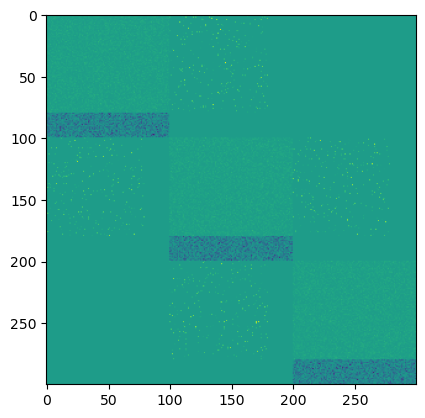

In [7]:
plt.imshow(wrec_init)

In [ ]:
torch.sum(temp3)

In [ ]:
torch.sum(wrec_init)

# train a full-rank RNN

In [8]:


net.non_linearity = torch.relu
net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=20, lr=lr, batch_size=100, 
      mask_gradients = False, keep_best=True, cuda=True, early_stop=0.2)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)


loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

# save the model
# torch.save(net.state_dict(), f'../models/TF{size}.pt')

Training...


TypeError: unsupported operand type(s) for -: 'Tensor' and 'tuple'

In [11]:
attributes = net.__dict__

In [12]:
attributes['non_linearity']

<function torch._VariableFunctionsClass.relu>

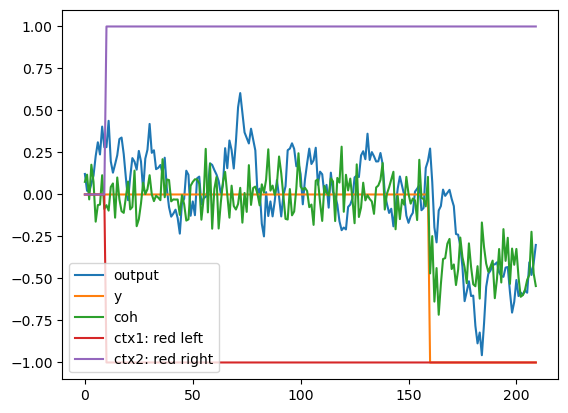

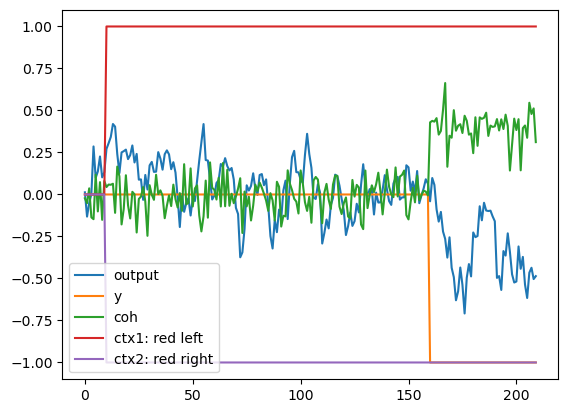

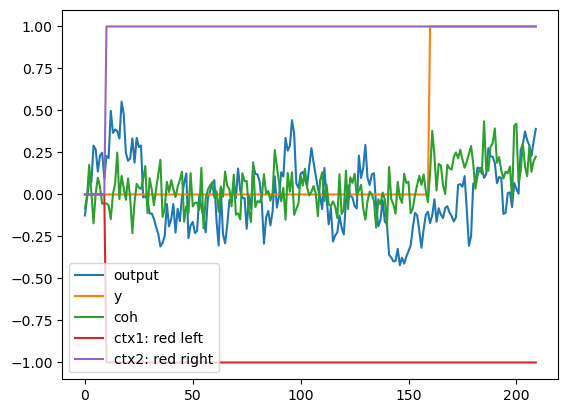

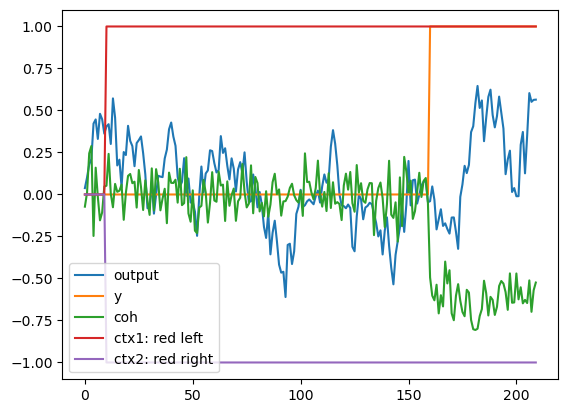

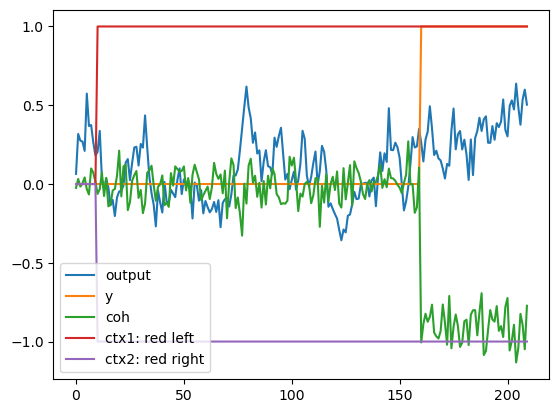

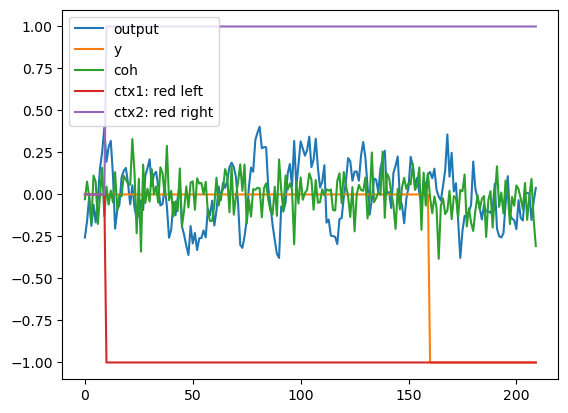

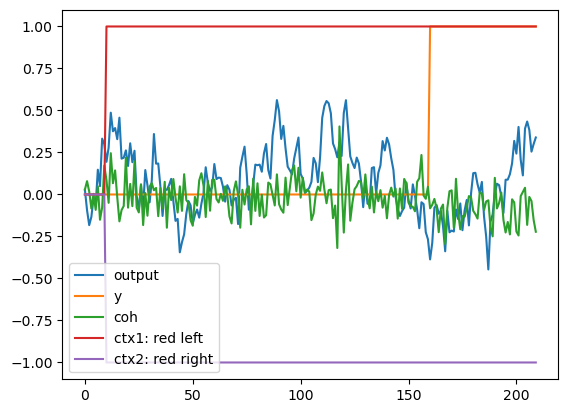

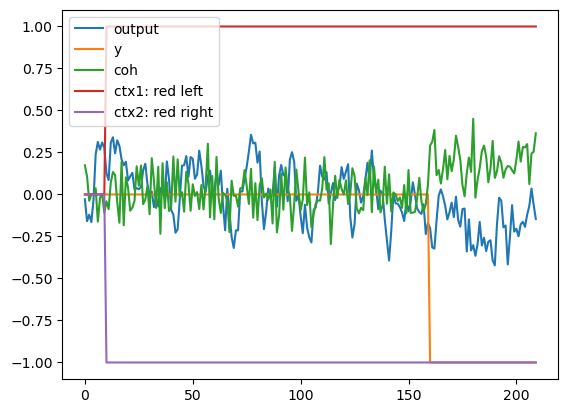

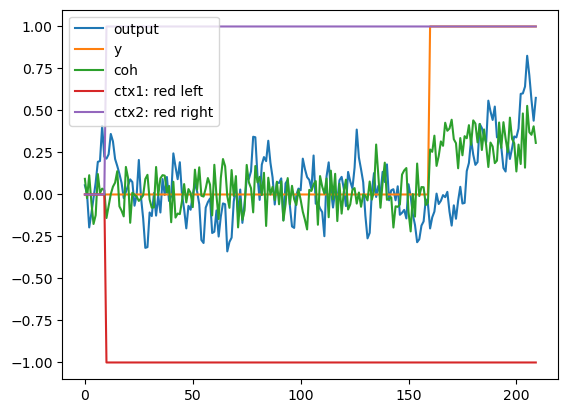

In [13]:
for n in range(1, 10):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

In [14]:
traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)
# traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

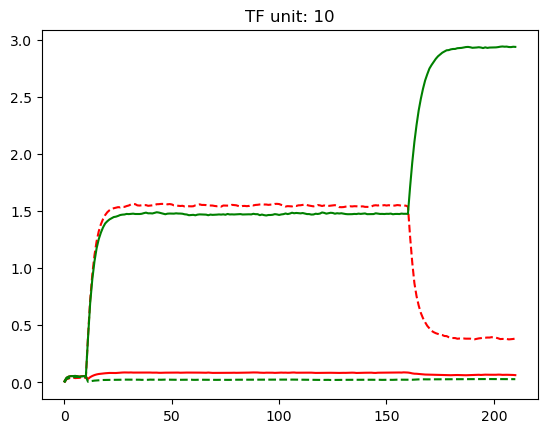

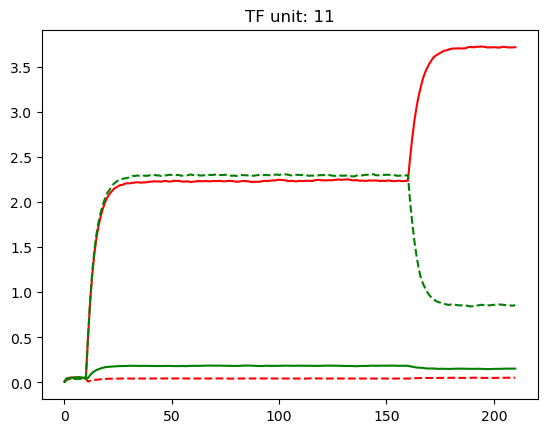

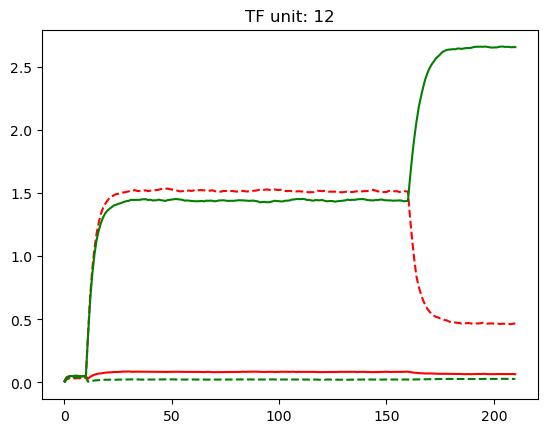

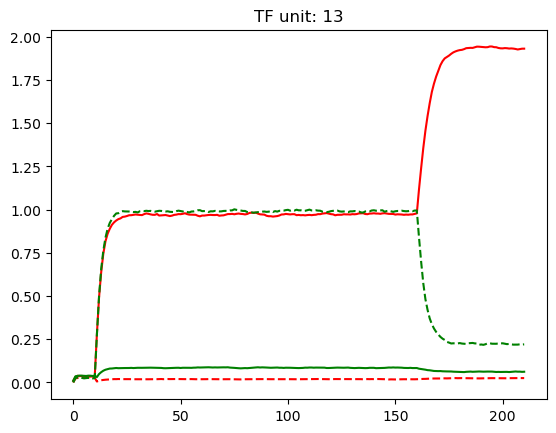

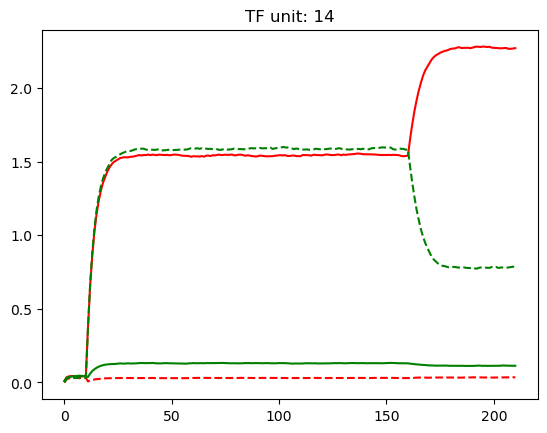

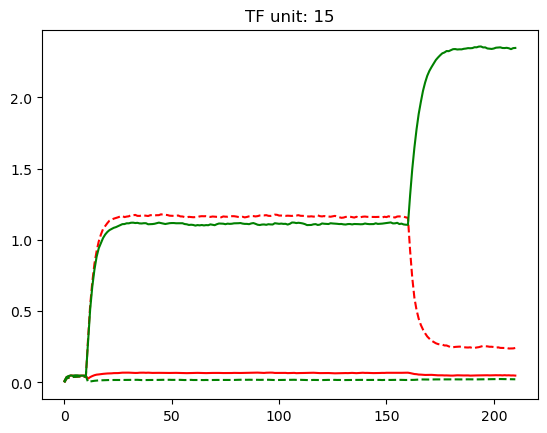

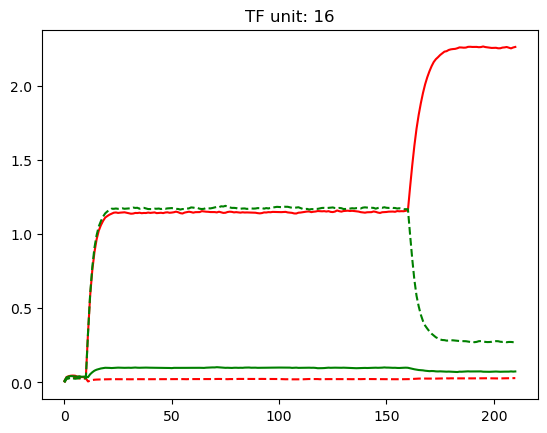

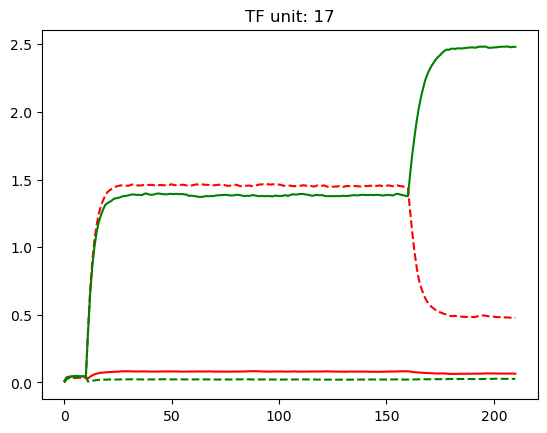

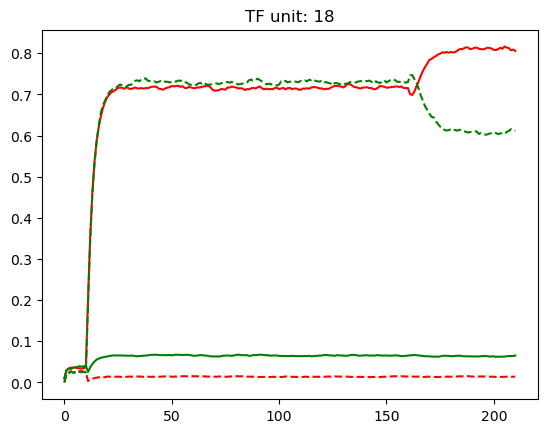

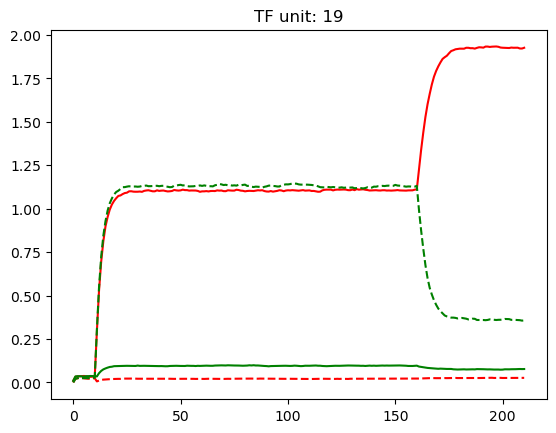

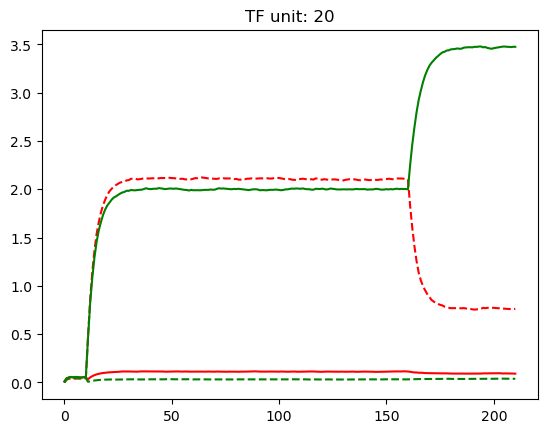

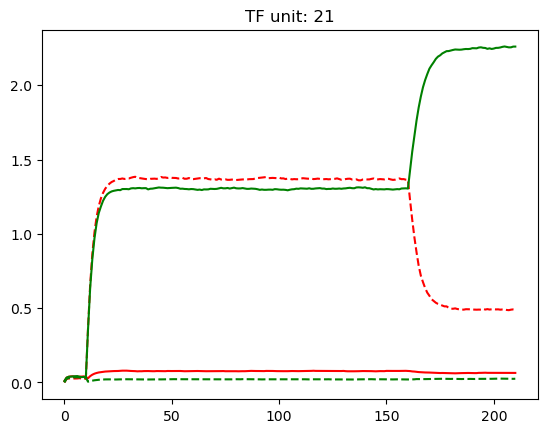

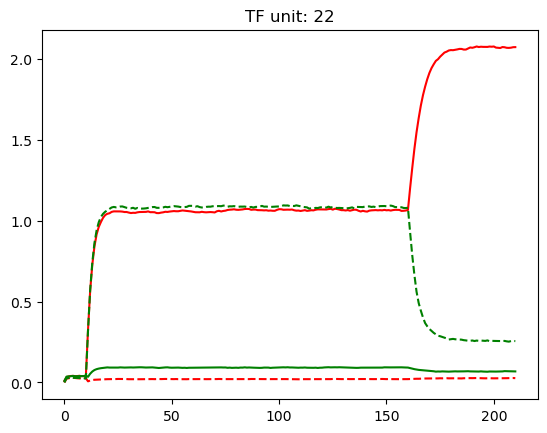

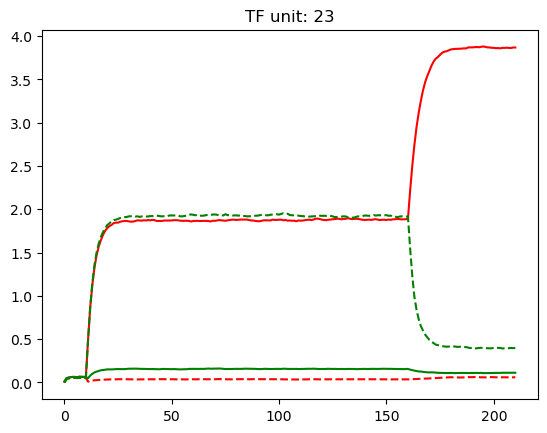

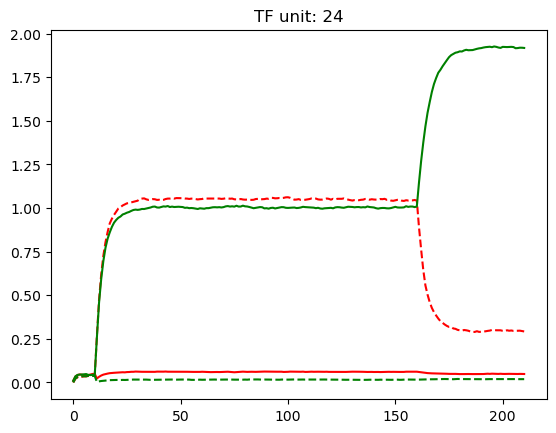

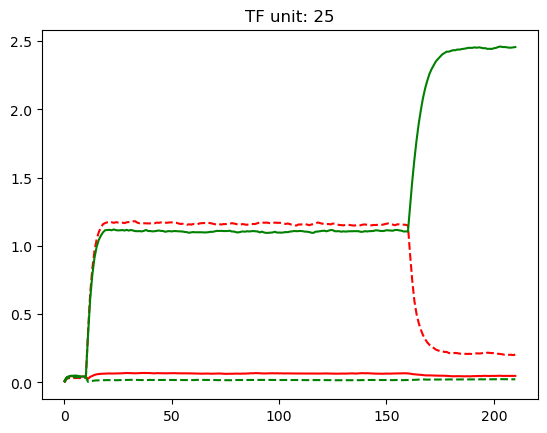

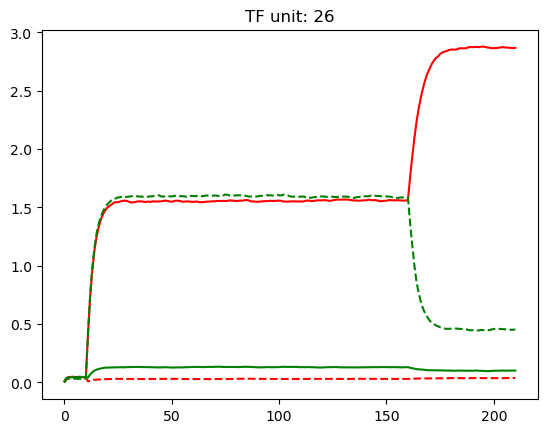

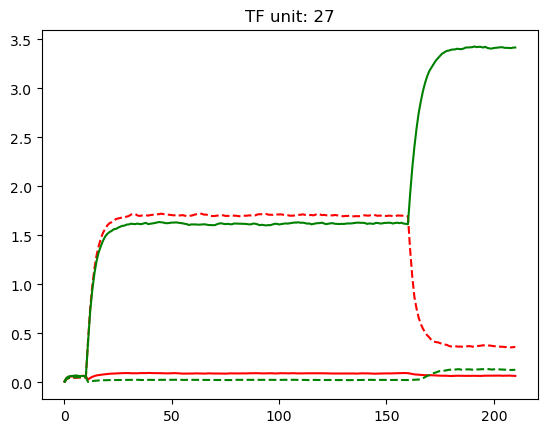

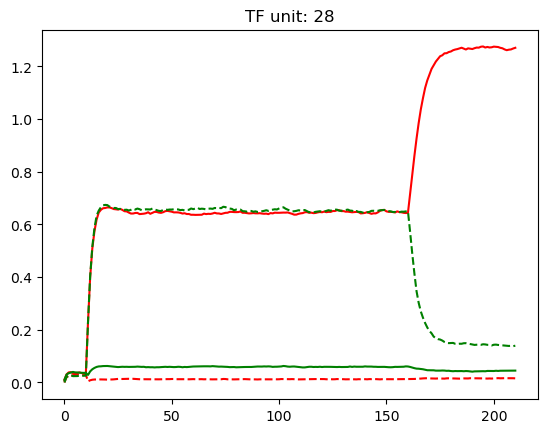

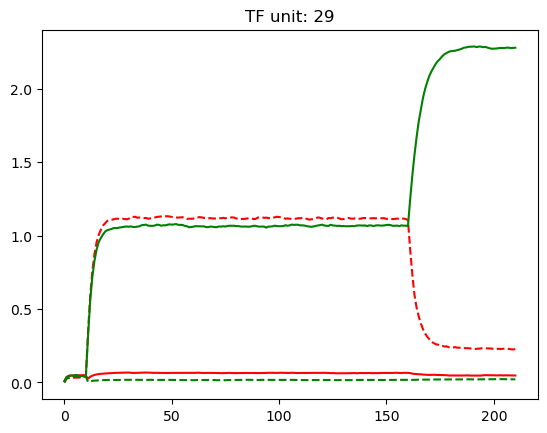

In [17]:
for n in range(10,30):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

# plot the connectivity matrix


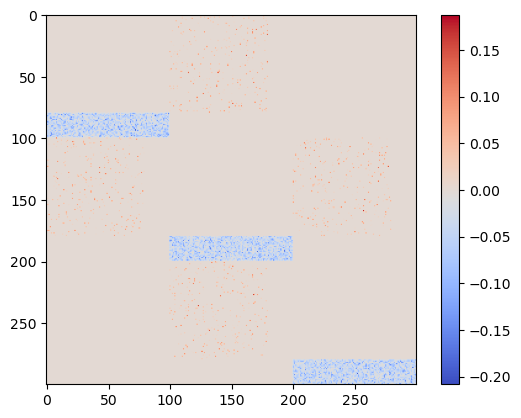

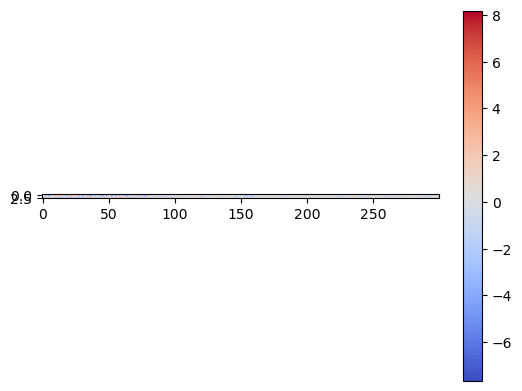

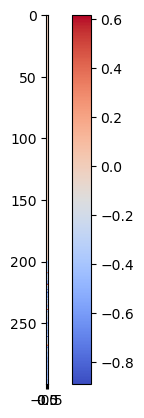

In [22]:
a = (net.wrec).detach().numpy()
plt.imshow(a)
plt.colorbar()
plt.set_cmap('coolwarm')
plt.show()

b = (net.wi).detach().numpy()
plt.imshow(b)
plt.colorbar()
plt.set_cmap('coolwarm')
plt.show()

c = (net.wo).detach().numpy()
plt.imshow(c)
plt.colorbar()
plt.set_cmap('coolwarm')
plt.show()


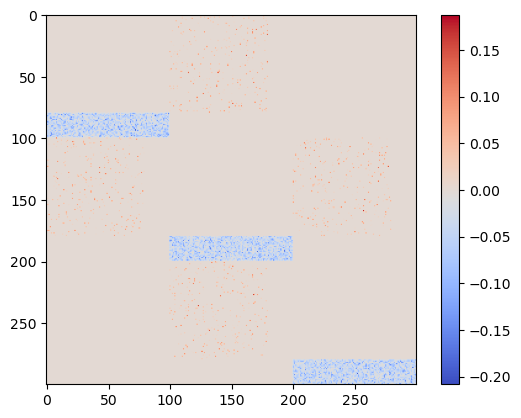

In [24]:
with torch.no_grad():
    net.wi.copy_(net.wi*wi_mask)

    net.wo.copy_(net.wo*wo_mask)
    net.wrec.copy_(np.abs(net.wrec)*wrec_mask)

# save the model
# torch.save(net.state_dict(), f'../models/TFconn{size}.pt')

netwi = net.wi.detach().numpy()
netwo = net.wo.detach().numpy()
netwrec = net.wrec.detach().numpy()

plt.imshow(netwrec)
plt.colorbar()


In [24]:
# save the model
# torch.save(net.state_dict(), f'../models/TFnoInputOverlapConn{size}.pt')

In [39]:
# load a full-rank RNN

net1 = FullRankRNN(3, size, 1, noise_std, alpha)
net1.load_state_dict(torch.load(f'../models/TFnoInputOverlapConn{size}.pt', map_location='cpu'))

x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net1, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.170, acc=1.000


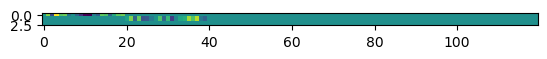

In [40]:
net1wi = net1.wi.detach().numpy()
net1wo = net1.wo.detach().numpy()
plt.imshow(net1wi)

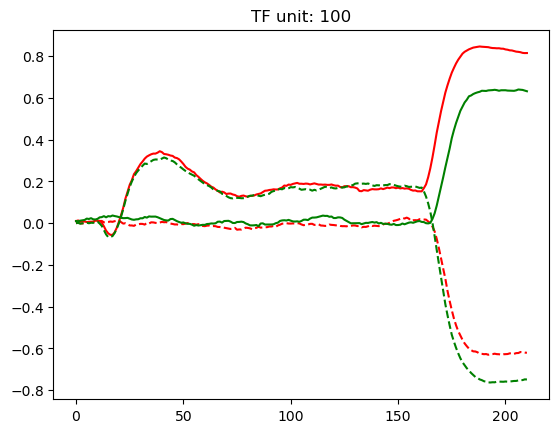

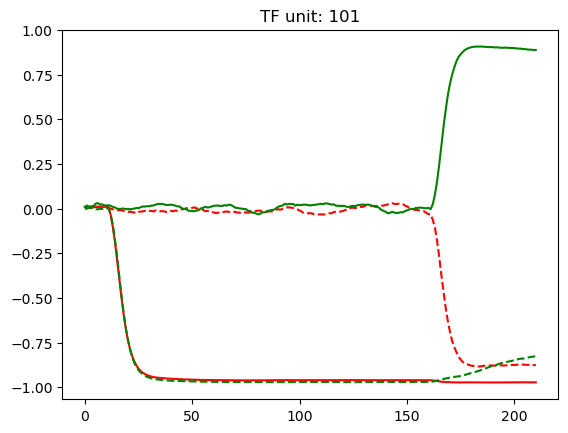

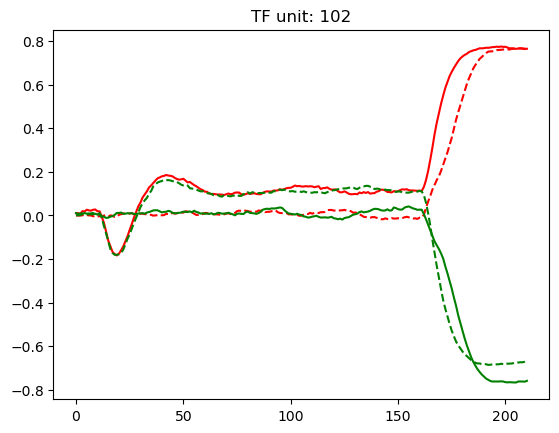

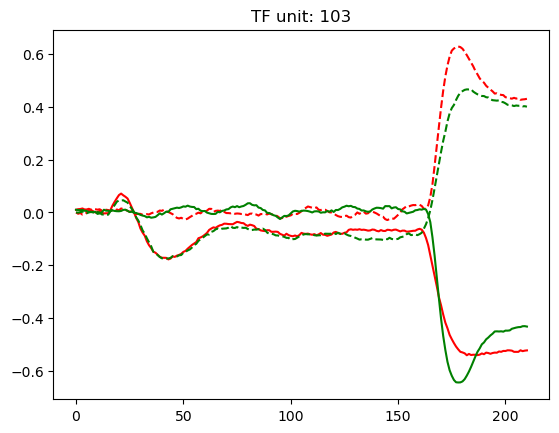

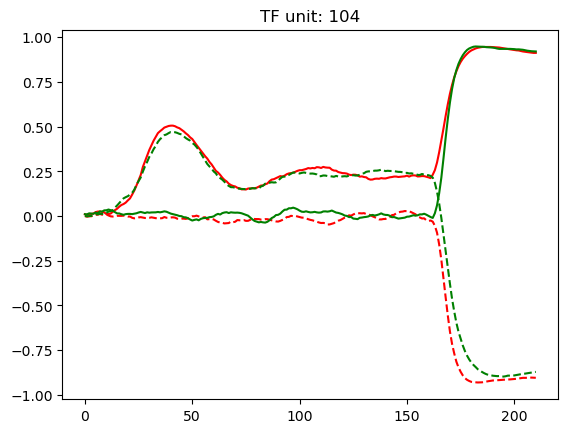

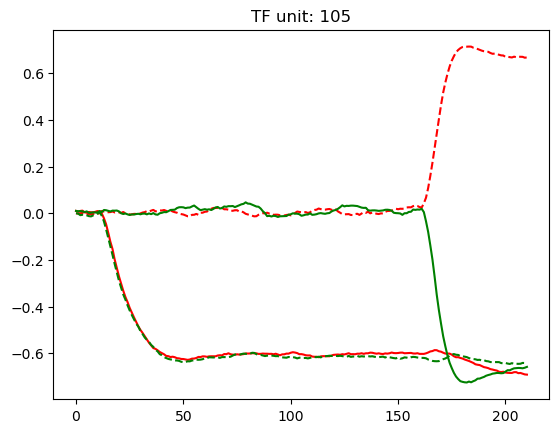

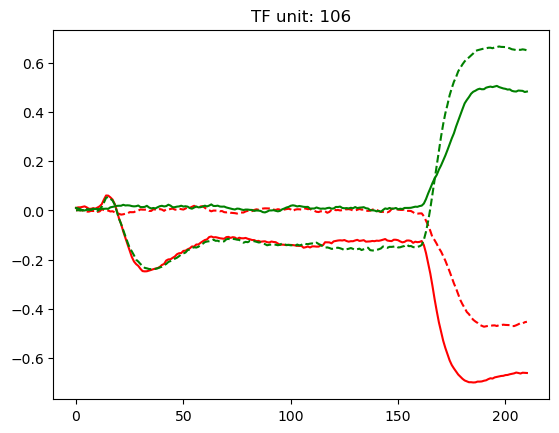

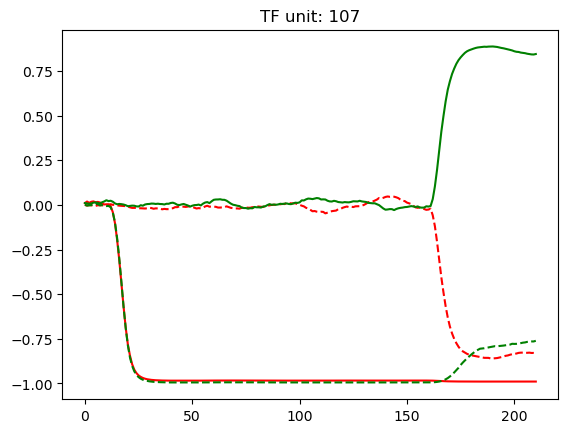

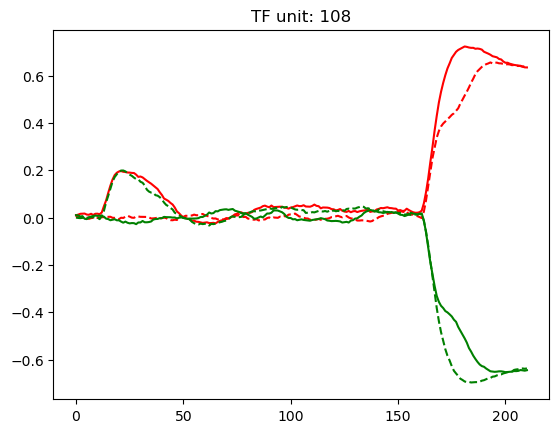

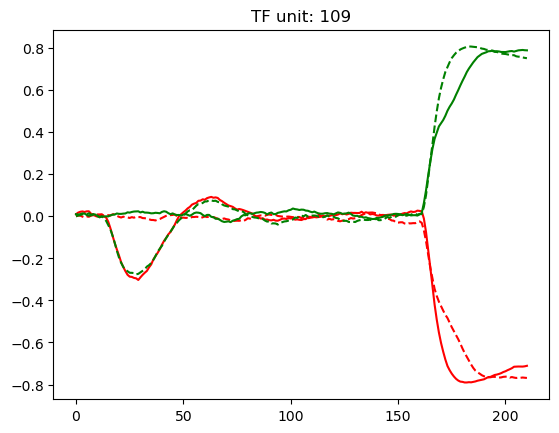

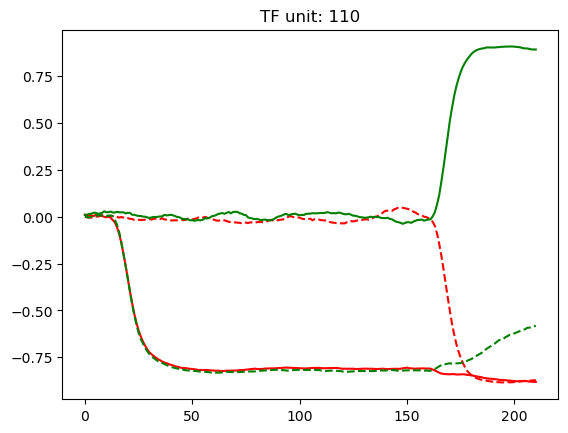

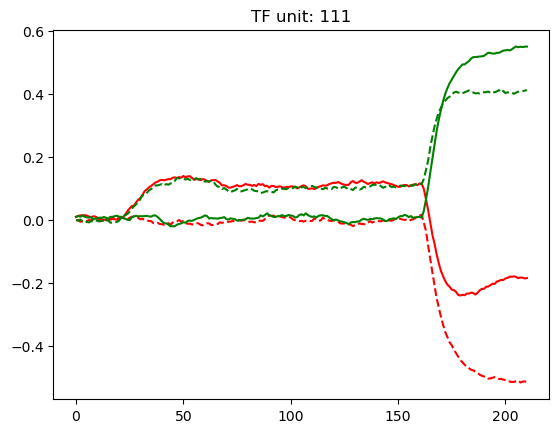

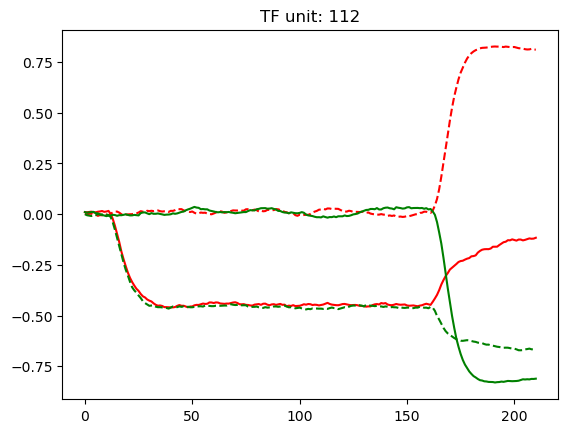

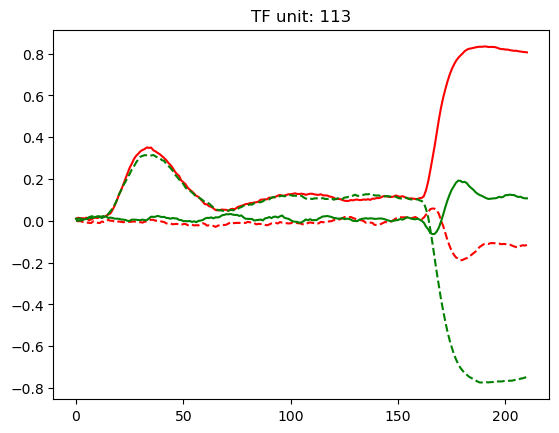

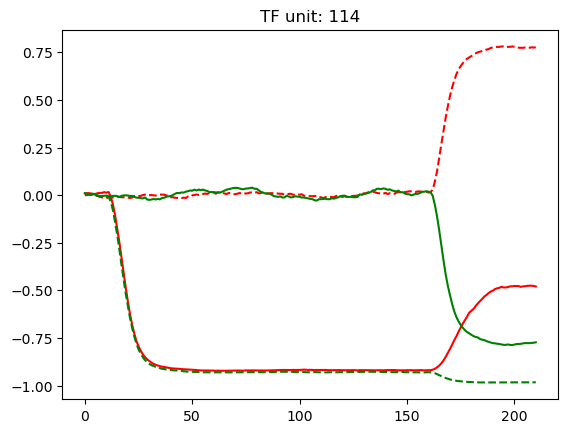

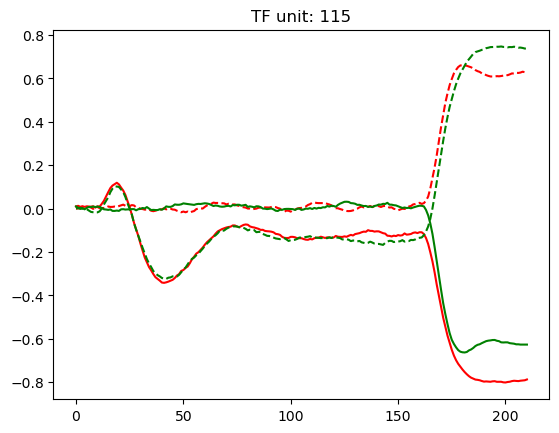

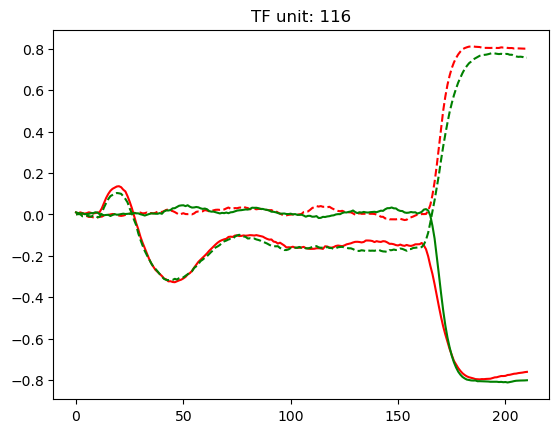

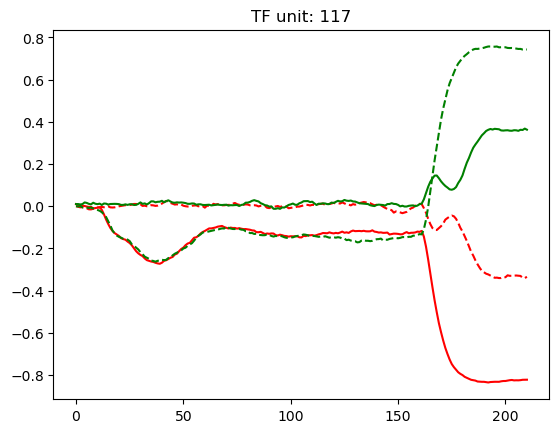

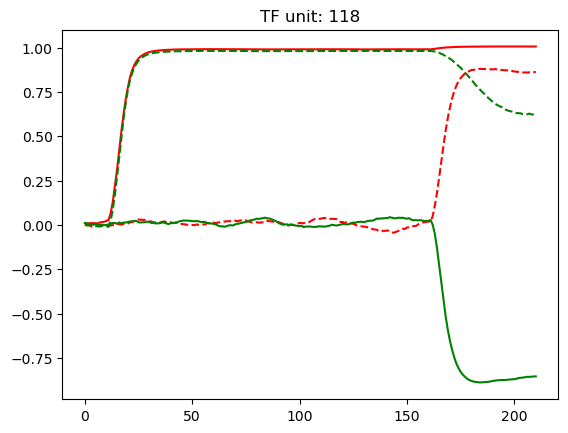

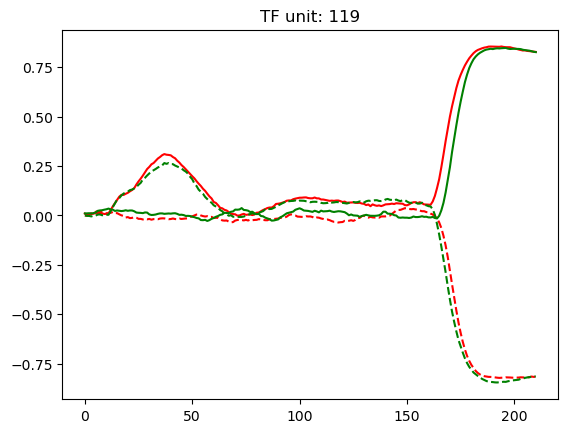

In [41]:
traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)
# traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(100,120):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

In [45]:
# define some parameters
# hidden_size: # units in low-rank RNN (should match that in full-rank RNN)
hidden_size = 120
rank = 2

In [46]:


# reduce the rank of connectivity matrix 
wi_init = net1.wi.detach()
wo_init = net1.wo.detach() * hidden_size
print(wo_init.std())
wrec = net1.wrec.detach().cpu().numpy()
u, s, v = np.linalg.svd(wrec)
m_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net1.wrec.device) * sqrt(hidden_size)
n_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net1.wrec.device) * sqrt(hidden_size)
print(m_init.std())
print(n_init.std())

print(m_init.shape)
print(n_init.shape)

tensor(5.0611)
tensor(2.5874)
tensor(1.0019)
torch.Size([120, 2])
torch.Size([120, 2])


In [47]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(1000)

# We see that the rank-1 network 
net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init)

net_lo.non_linearity = torch.tanh
net_lo.out_non_linearity = torch.eye


train(net_lo, x_train, y_train, mask_train, n_epochs=20, lr=lr, batch_size=50, keep_best=True, cuda=True, clip_gradient=1, early_stop=0.2)
x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_lo)

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')



Training...
initial loss: 3.232
epoch 0:  loss=2.124  (took 1.92 s) *
epoch 1:  loss=0.951  (took 1.81 s) *
epoch 2:  loss=0.858  (took 1.81 s) *
epoch 3:  loss=0.804  (took 1.80 s) *
epoch 4:  loss=0.706  (took 1.81 s) *
epoch 5:  loss=0.637  (took 1.81 s) *
epoch 6:  loss=0.576  (took 1.81 s) *
epoch 7:  loss=0.476  (took 1.81 s) *
epoch 8:  loss=0.411  (took 1.81 s) *
epoch 9:  loss=0.372  (took 1.81 s) *
epoch 10:  loss=0.334  (took 1.80 s) *
epoch 11:  loss=0.309  (took 1.86 s) *
epoch 12:  loss=0.280  (took 1.81 s) *
epoch 13:  loss=0.271  (took 1.81 s) *
epoch 14:  loss=0.253  (took 1.82 s) *
epoch 15:  loss=0.247  (took 1.80 s) *
epoch 16:  loss=0.224  (took 1.80 s) *
epoch 17:  loss=0.221  (took 1.80 s) *
epoch 18:  loss=0.203  (took 1.80 s) *
epoch 19:  loss=0.195  (took 1.80 s) *
loss=0.192, acc=1.000


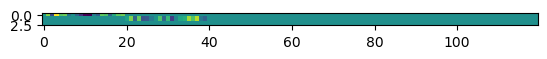

In [48]:

net1lowi = net_lo.wi.detach().numpy()
net1lowo = net_lo.wo.detach().numpy()
plt.imshow(net1lowi)

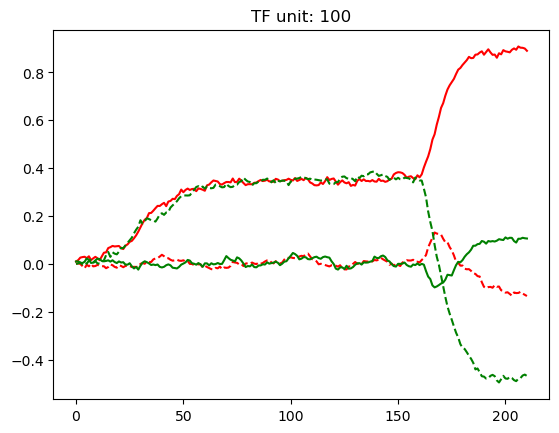

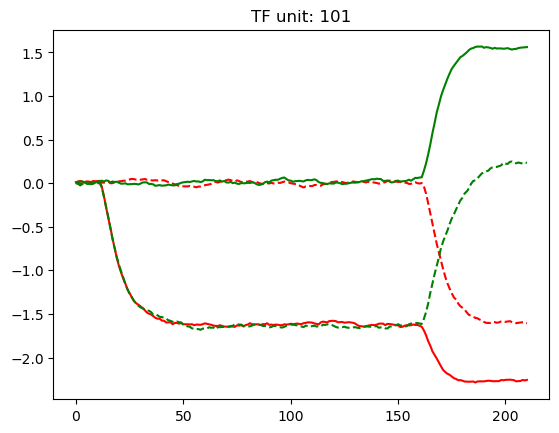

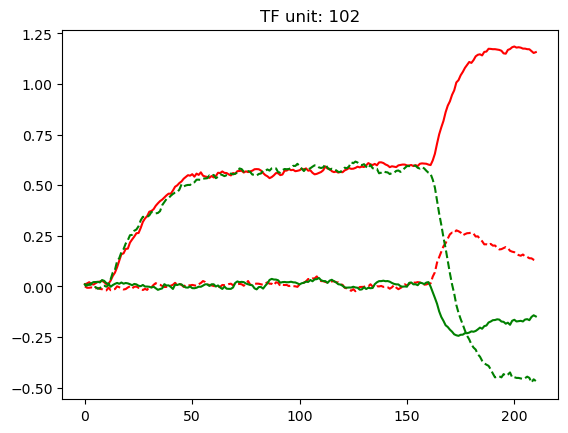

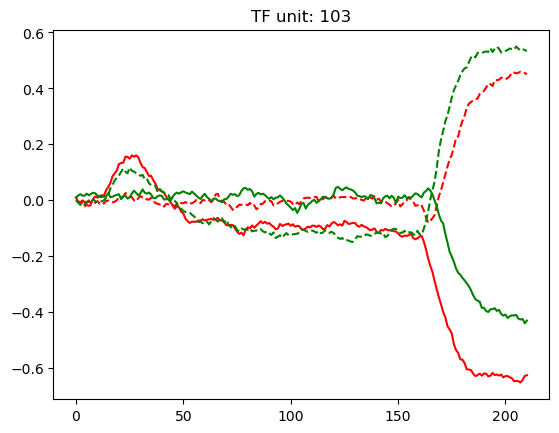

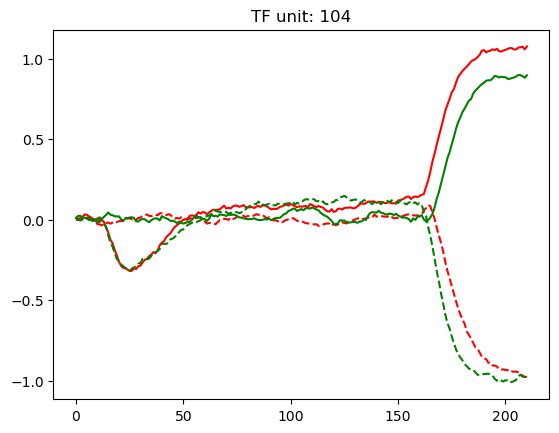

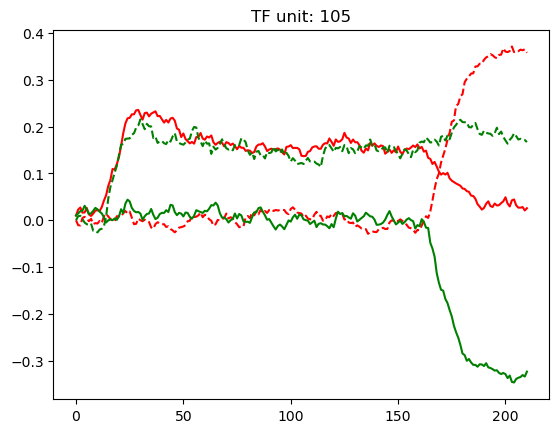

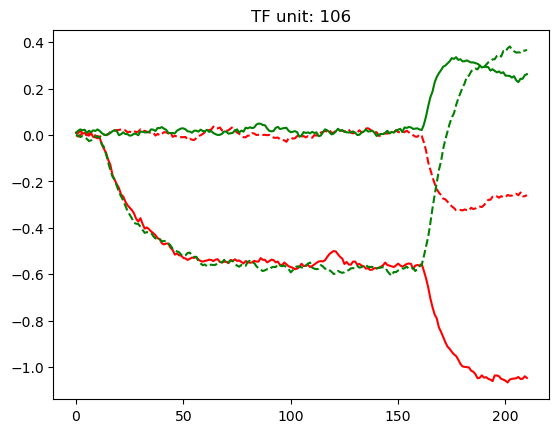

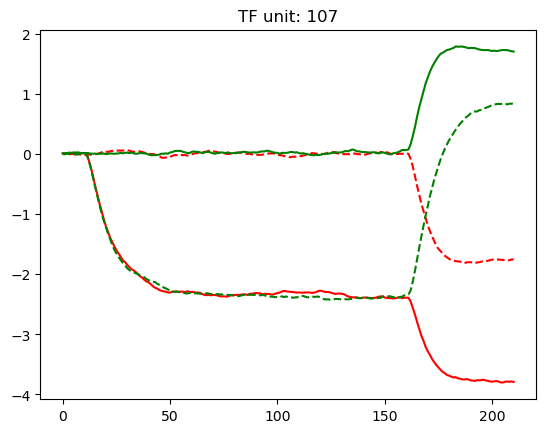

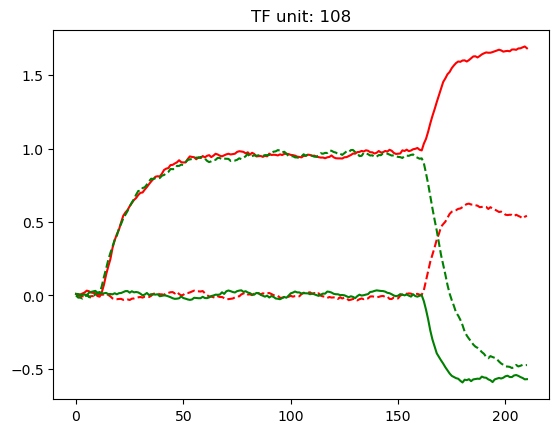

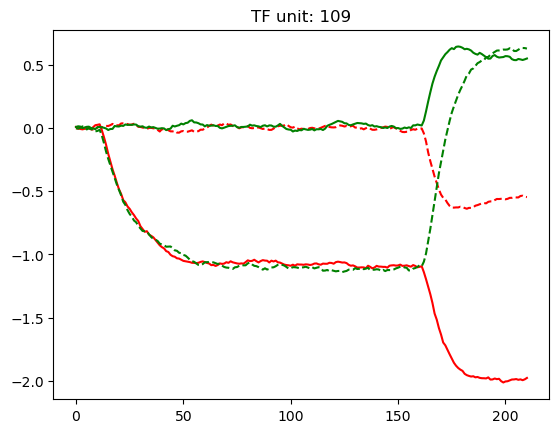

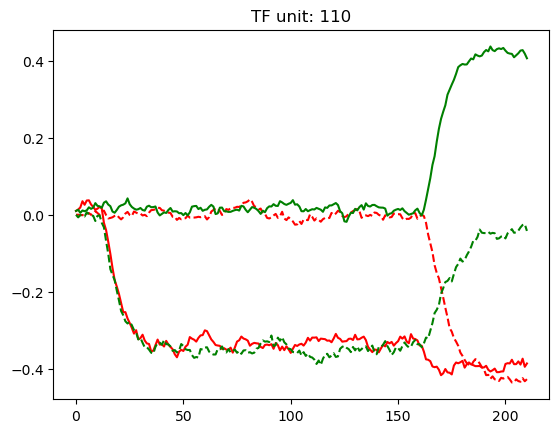

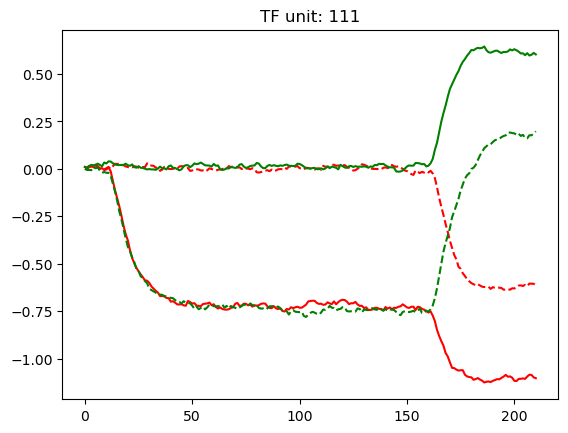

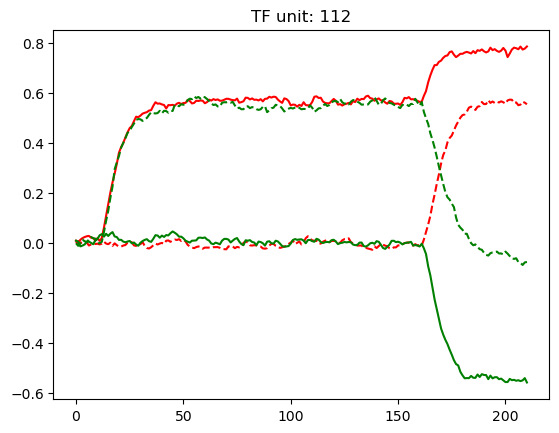

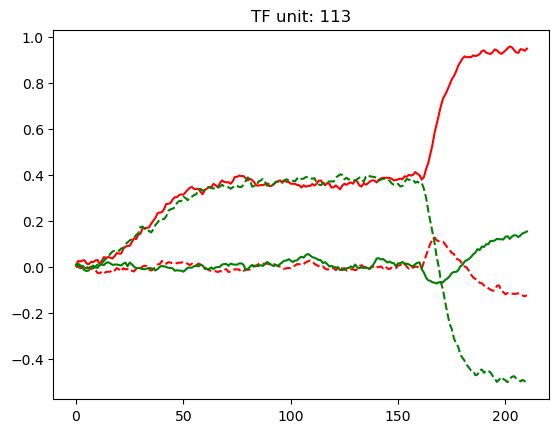

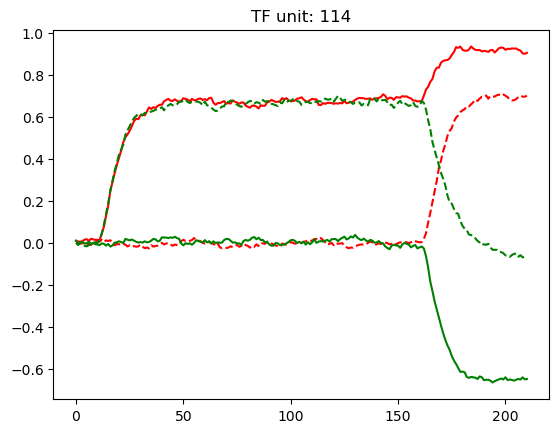

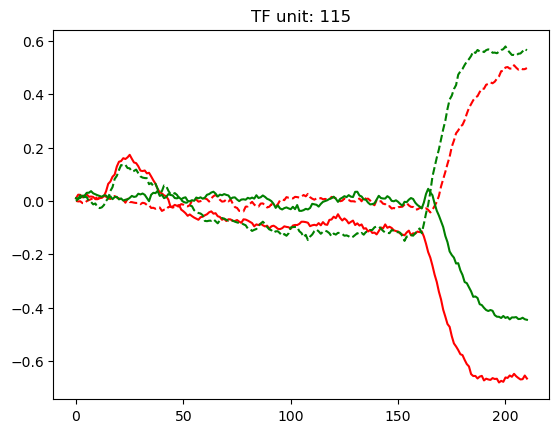

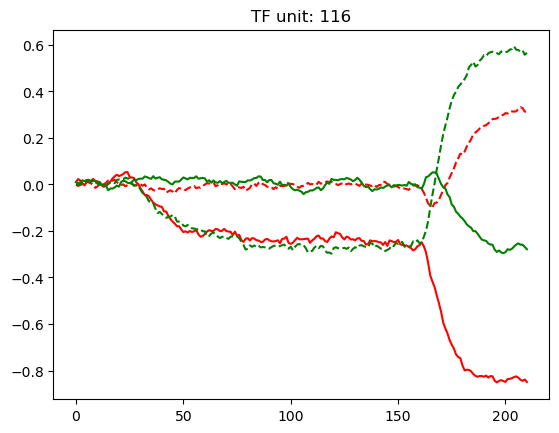

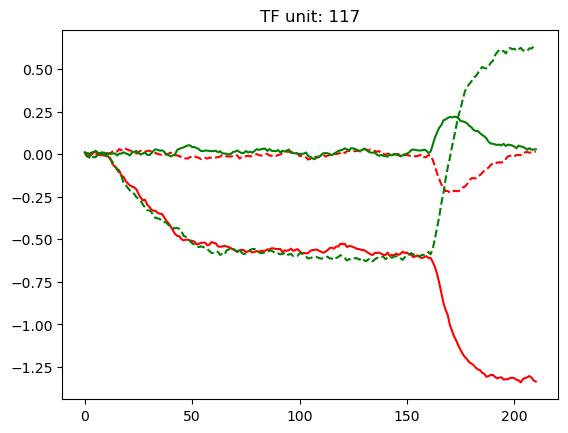

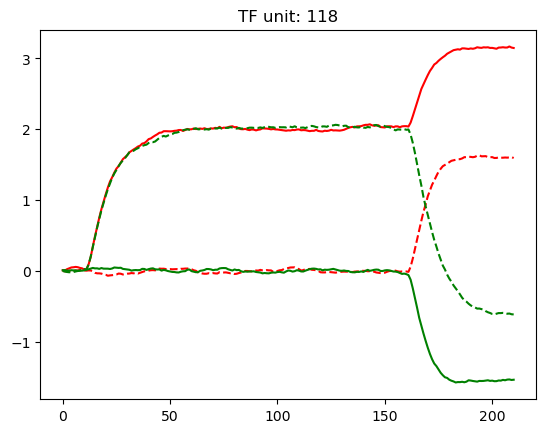

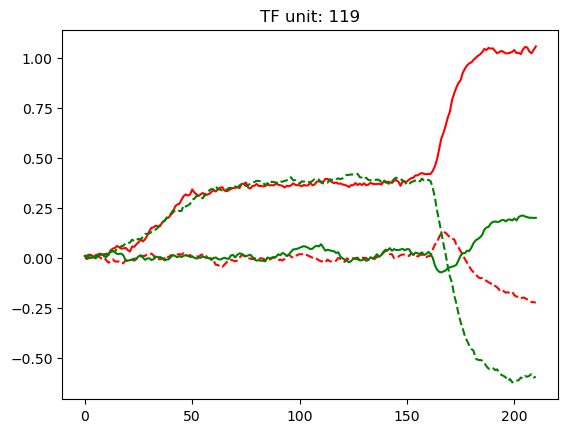

In [49]:
traj1 = traj.detach().numpy()

# traj1 = np.tanh(traj1)
decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(100,120):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

In [50]:
net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
# n3 = net_lo.n[:, 2].detach().numpy()
# n4 = net_lo.n[:, 3].detach().numpy()


# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
# m3 = net_lo.m[:, 2].detach().numpy()
# m4 = net_lo.m[:, 3].detach().numpy()


wo = net_lo.wo.detach().squeeze().numpy()

In [51]:
# 1st way to generate low-traj
loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

loss=0.189, acc=1.000


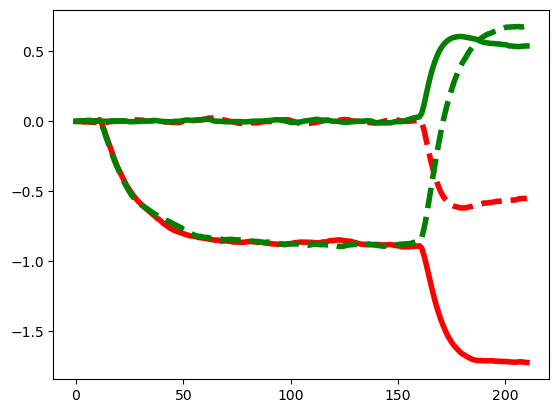

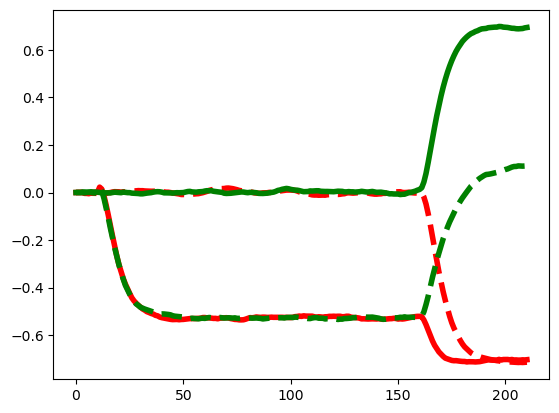

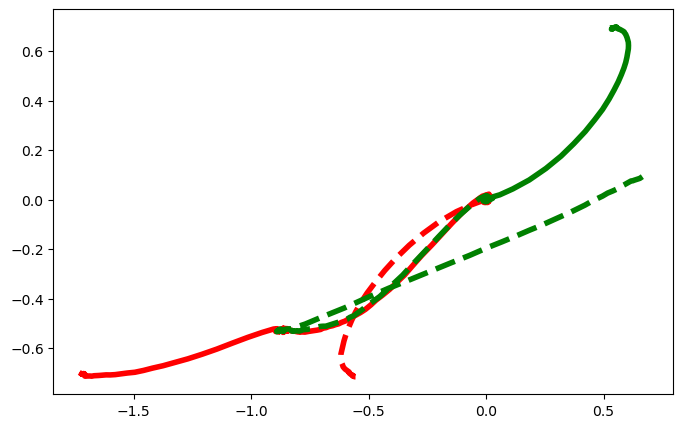

In [52]:
# project full rank rnn traj on m1 vector
# kap1 = trajFull @ m1 / size
# kap2 = trajFull @ m2 / size

# project low rank rnn traj on m1 vector
kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size
kap4 = trajLow @ m4 / size


colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
plt.figure()
for i in range(4):
    plt.plot(kap1[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(kap2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

# plt.figure()
# for i in range(4):
#     plt.plot(kap3[i], c=colors[i], lw=4, ls=lineStyle[i])
# plt.show()

# plt.figure()
# for i in range(4):
#     plt.plot(kap4[i], c=colors[i], lw=4, ls=lineStyle[i])
# plt.show()

plt.subplots(figsize=(8,5))
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
     plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls=lineStyle[i])


(844, 120)


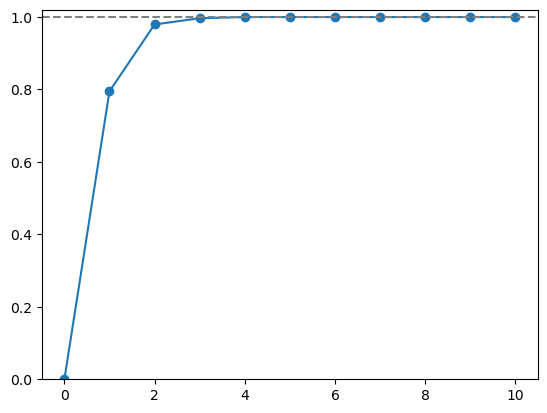

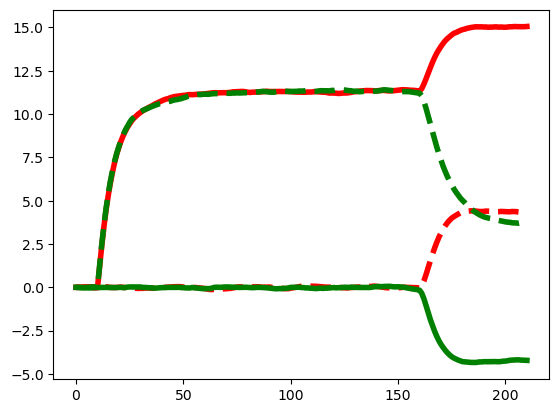

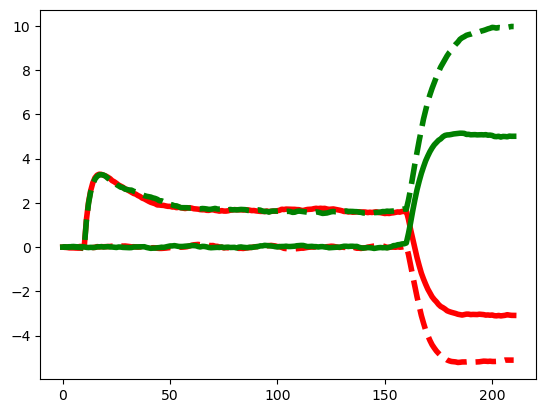

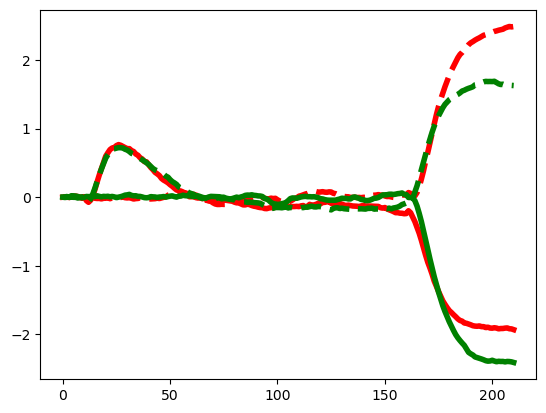

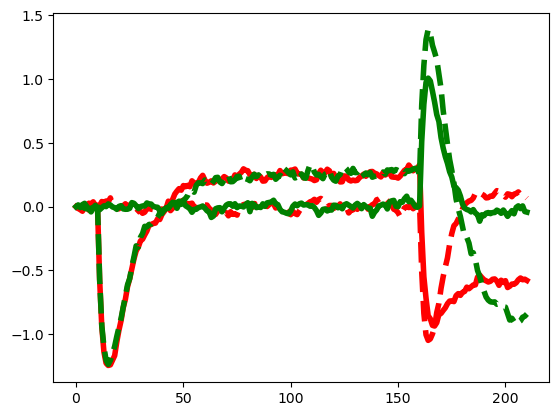

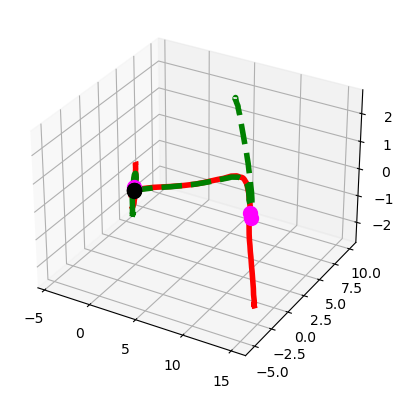

In [53]:
# low rank RNN pca
TOn = 10
COn = 160

pca = plot.pca_cumvar(trajLow, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()

labels = ['RL', 'RR', 'GL', 'GR']

ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = trajLow @ ax1
k2 = trajLow @ ax2
k3 = trajLow @ ax3
k4 = trajLow @ ax4

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
            marker='.', s=400)
    ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
            marker='.', s=400)

# ax.view_init(elev=38, azim=90)
plt.show()

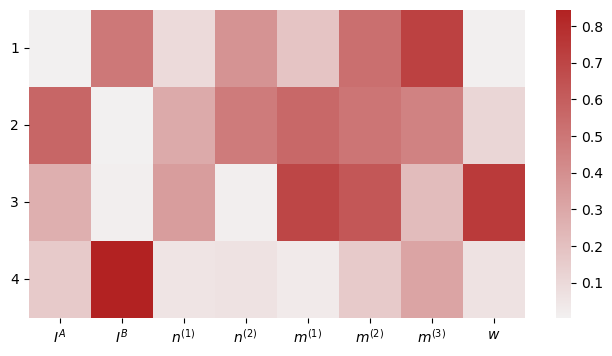

In [23]:
vecs_pca = [ax1, ax2, ax3, ax4]
vecs_fit = [wi1, wi2, n1, n2, m1, m2, m3, wo]

helpers.overlap_matrix2(vecs_pca, vecs_fit, norm='l2', figsize=(8,4), abs=True, cmap='abs')
# plt.xlabel('Fitted connectivity')
# plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 8, 1), ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$m^{(3)}$','$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['1', '2', '3', '4'], rotation='horizontal')
plt.show()

In [62]:
# 1st way to generate low-traj
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000, coherences = [-0.9,0.9])

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)


kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size
kap4 = trajLow @ m4 / size

loss=0.152, acc=1.000


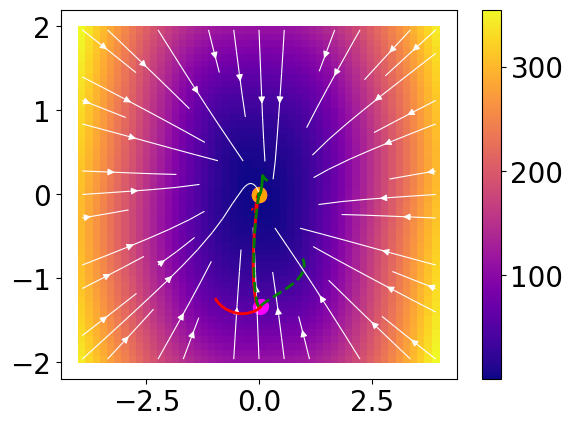

In [63]:
# whole epoch
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m2, -4, 4, -2, 2)
mappable.set_cmap('plasma')
plt.colorbar(mappable)

for i in range(4):
     plt.plot(kap1[i], kap2[i], c=colors[i], lw=2, ls=lineStyle[i])
     plt.scatter(kap1[i, TOn], kap2[i, TOn], c= 'orange',
            marker='.', s=400)  
     plt.scatter(kap1[i, COn], kap2[i, COn], c= 'magenta',
            marker='.', s=400)  
        
# # plt.savefig('TFtraj4_1.pdf', bbox_inches='tight')
        
plt.show()

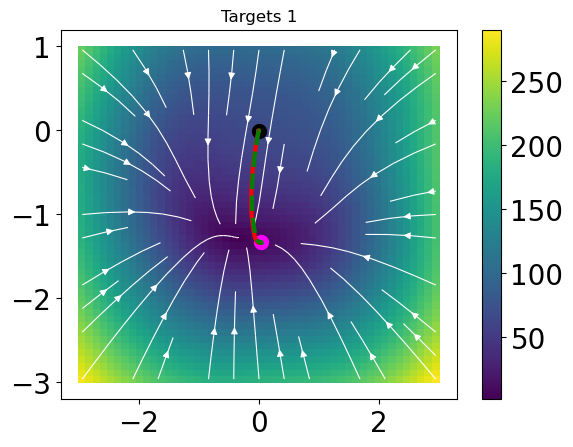

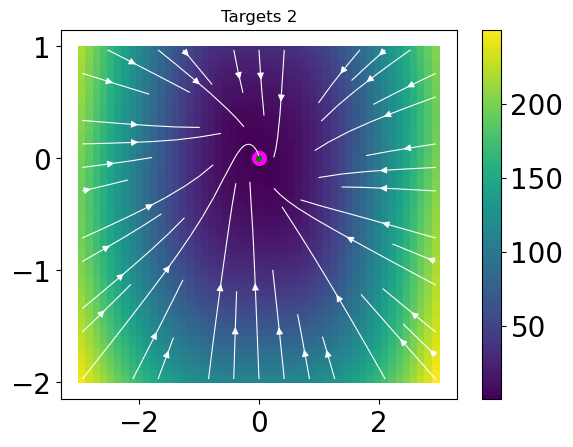

In [64]:
# only target epoch
kap1T = kap1[:,:160]
kap2T = kap2[:,:160]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m2, -3, 3, -3, 1, input=torch.tensor([0.,1, 0]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap1T[0], kap2T[0], c=colors[0], lw=3, ls=lineStyle[0])
plt.plot(kap1T[3], kap2T[3], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap1[0, TOn], kap2[0, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[0, COn], kap2[0, COn], c= 'magenta',
    marker='.', s=400) 
        
plt.title('Targets 1')        
# plt.savefig('TFT1.pdf', bbox_inches='tight')
        
plt.show()

# target 1 epoch 
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m2, -3, 3, -2, 1, input=torch.tensor([0.,0, 1]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1T[1], kap2T[1], c=colors[0], lw=3, ls=lineStyle[1])
plt.plot(kap1T[2], kap2T[2], c=colors[3], lw=3, ls=lineStyle[2])
plt.scatter(kap1[1, TOn], kap2[1, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[1, COn], kap2[1, COn], c= 'magenta',
    marker='.', s=400) 
        
plt.title('Targets 2')        
# plt.savefig('TFT2.pdf', bbox_inches='tight')
        
plt.show()


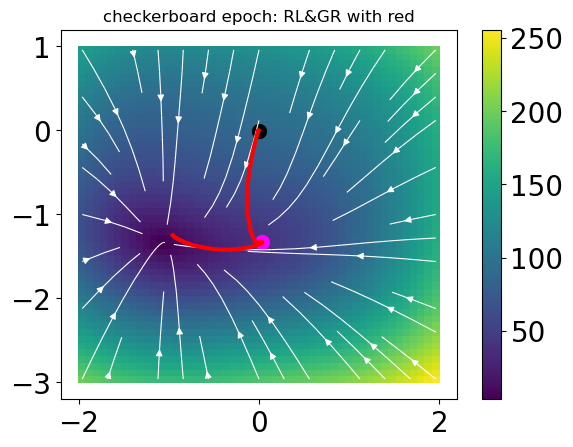

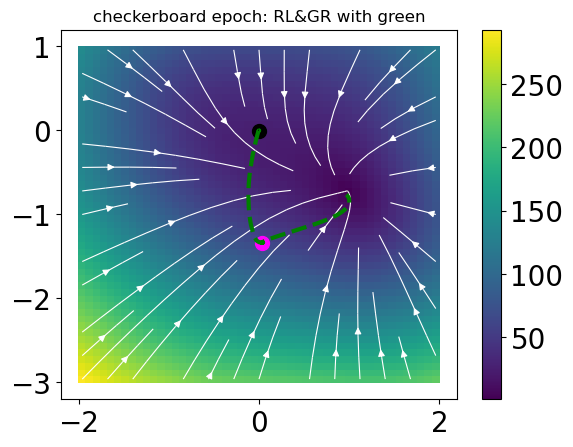

In [65]:

# checkerboard epoch
kap1C = kap1[:,160:]
kap2C = kap2[:,160:]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m2, -2, 2, -3, 1, input=torch.tensor([0.9,1, 0]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1[0], kap2[0], c=colors[0], lw=3, ls=lineStyle[0])
plt.scatter(kap1[0, TOn], kap2[0, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[0, COn], kap2[0, COn], c= 'magenta',
    marker='.', s=400) 

plt.title('checkerboard epoch: RL&GR with red')        
# plt.savefig('TFT1R.pdf', bbox_inches='tight')
        
plt.show()






# checkerboard epoch
kap1C = kap1[:,160:]
kap2C = kap2[:,160:]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m2, -2, 2, -3, 1, input=torch.tensor([-0.9,1, 0]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1[3], kap2[3], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap1[3, TOn], kap2[3, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[3, COn], kap2[3, COn], c= 'magenta',
    marker='.', s=400) 

plt.title('checkerboard epoch: RL&GR with green')        
# plt.savefig('TFT1G.pdf', bbox_inches='tight')
        
plt.show()



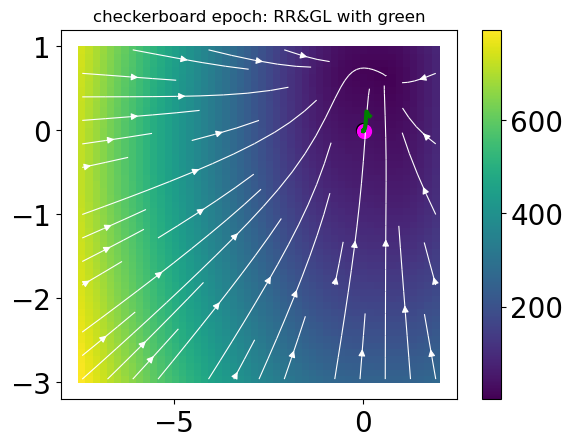

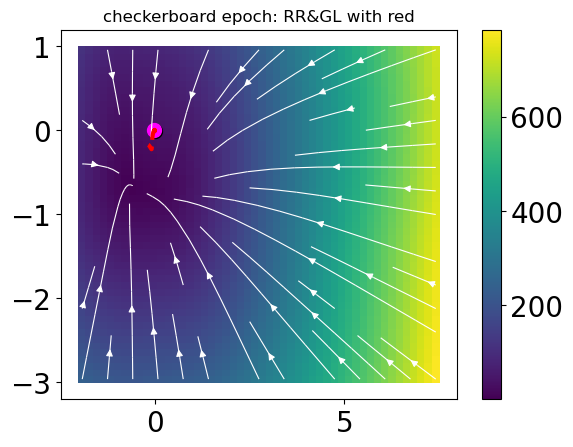

In [66]:

# checkerboard epoch
kap1C = kap1[:,160:]
kap2C = kap2[:,160:]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

[ax, mappable] = ranktwo.plot_field(net_lo, m1, m2, -7.5, 2, -3, 1, input=torch.tensor([-0.9,0, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap1[2], kap2[2], c=colors[2], lw=3, ls=lineStyle[2])
plt.scatter(kap1[2, TOn], kap2[2, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[2, COn], kap2[2, COn], c= 'magenta',
    marker='.', s=400) 

plt.title('checkerboard epoch: RR&GL with green')        
        
plt.show()







# checkerboard epoch
kap1C = kap1[:,160:]
kap2C = kap2[:,160:]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m2, -2, 7.5, -3, 1, input=torch.tensor([0.9,0, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1[1], kap2[1], c=colors[1], lw=3, ls=lineStyle[1])
plt.scatter(kap1[1, TOn], kap2[1, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[1, COn], kap2[1, COn], c= 'magenta',
    marker='.', s=400) 

plt.title('checkerboard epoch: RR&GL with red')        
        
plt.show()

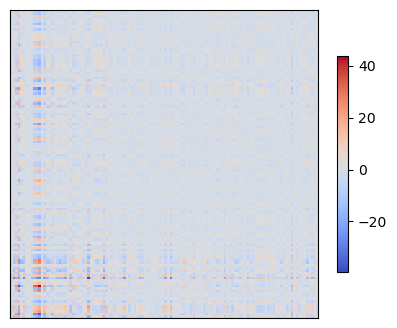

In [56]:
J = (net_lo.m @ net_lo.n.T).detach().numpy()
fig, ax = plt.subplots(figsize=(5,4))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
p = ax.matshow(J, cmap='coolwarm')
ax.set_xticks([])
ax.set_yticks([])
ax_cb = fig.colorbar(p, shrink=.7)
# ax_cb.set_ticks([-20, 0, 20])

norm = ax_cb.norm

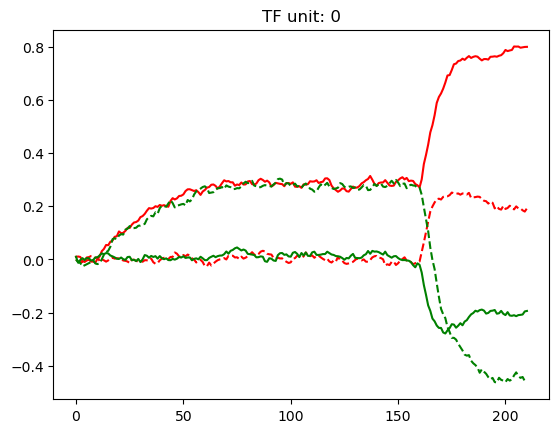

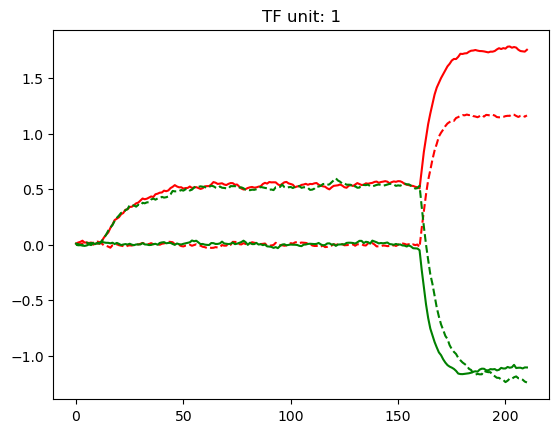

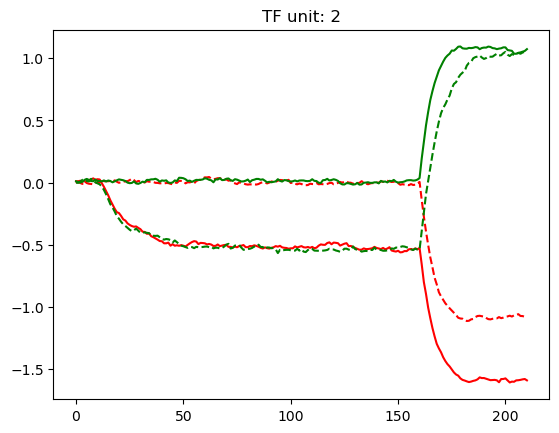

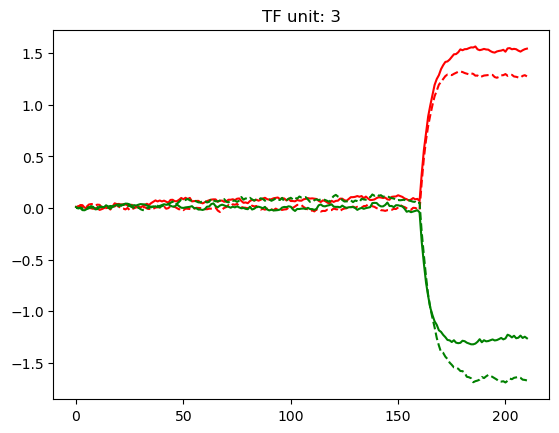

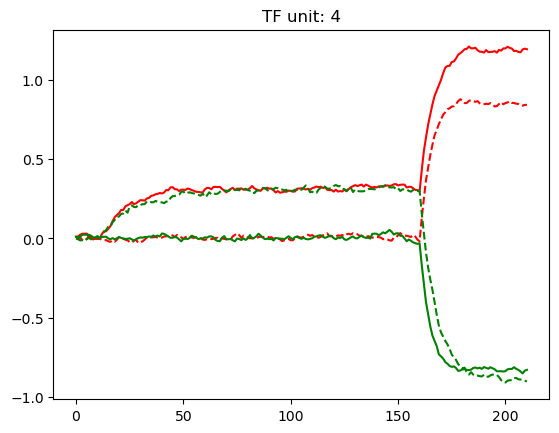

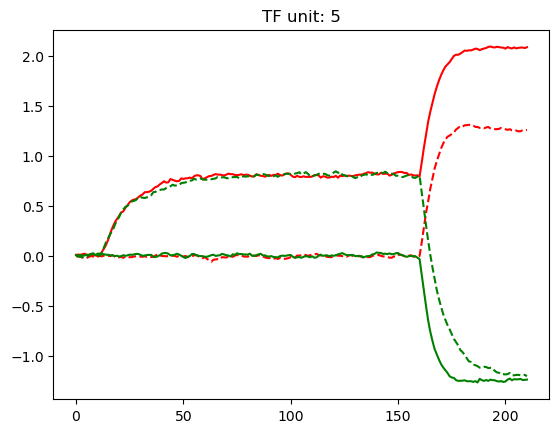

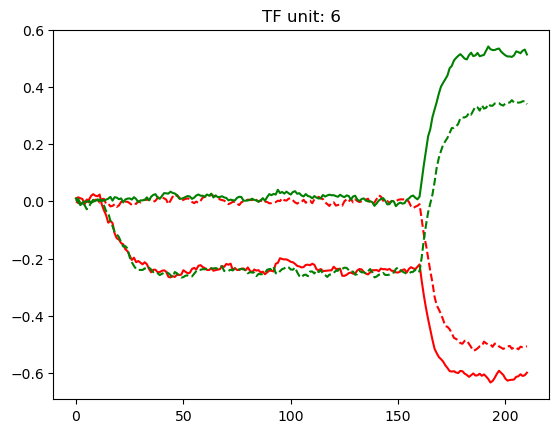

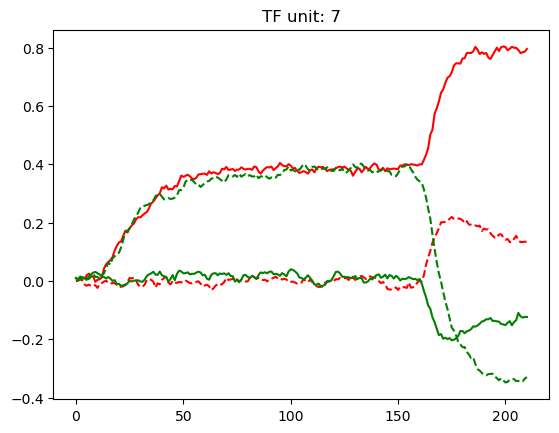

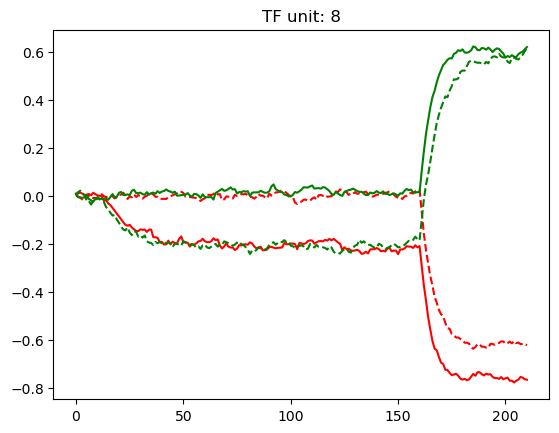

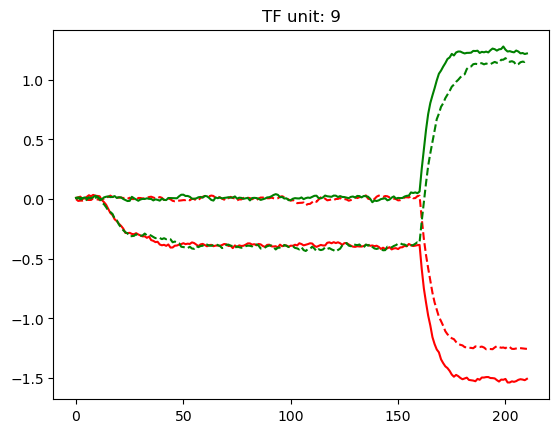

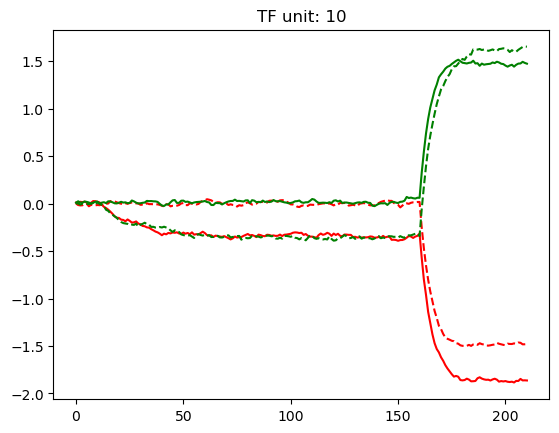

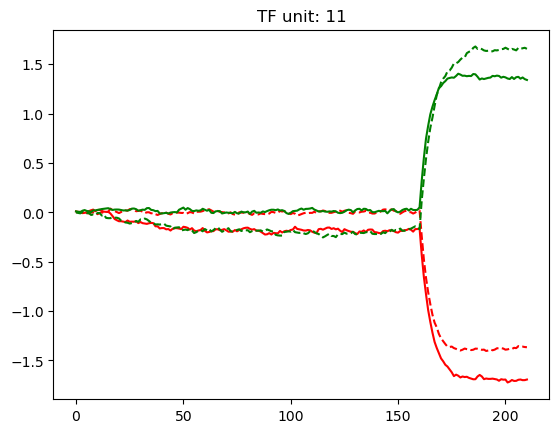

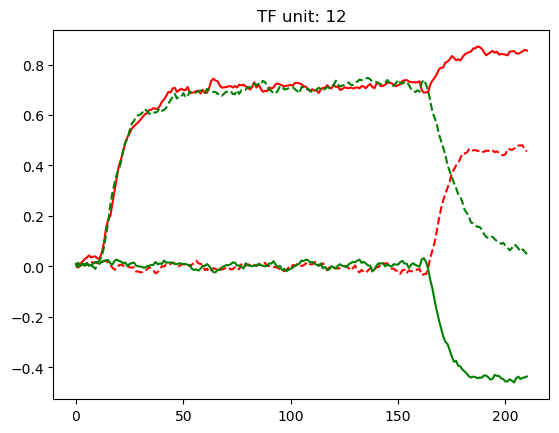

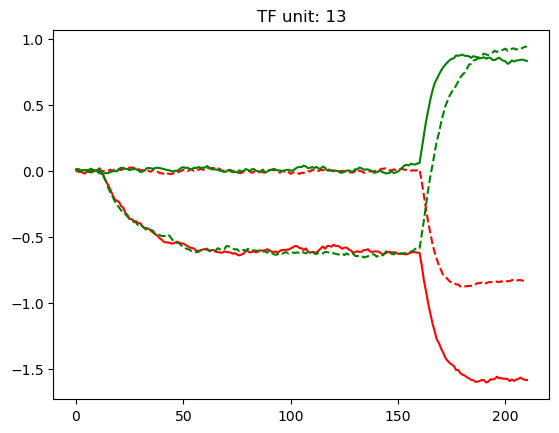

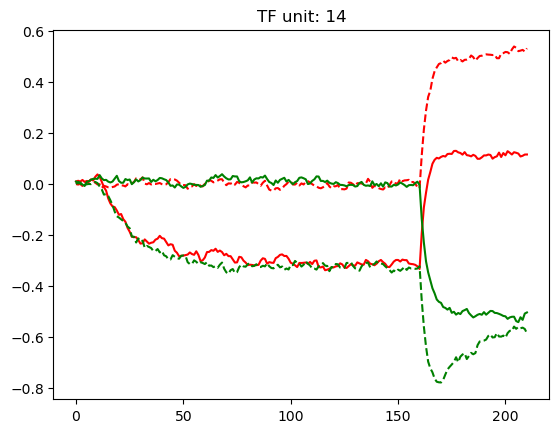

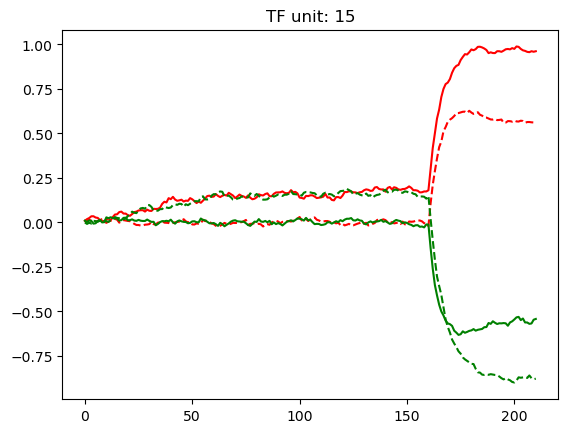

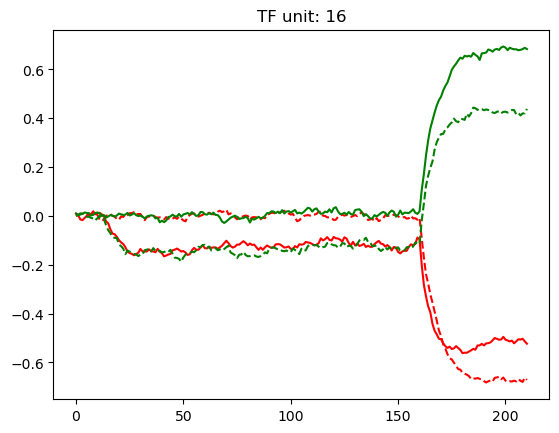

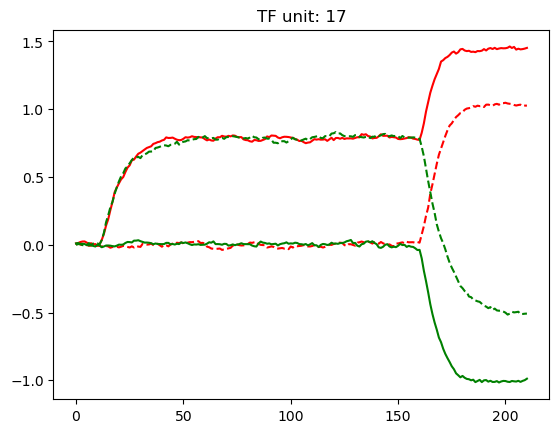

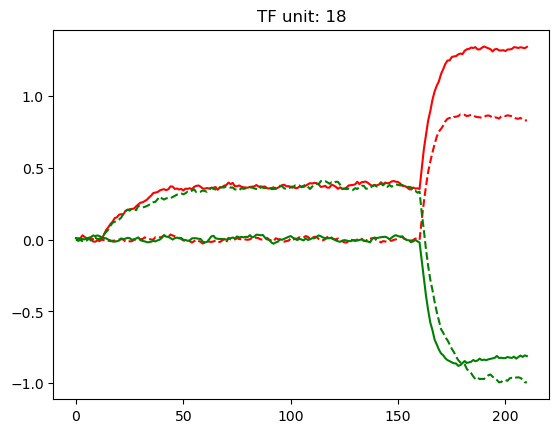

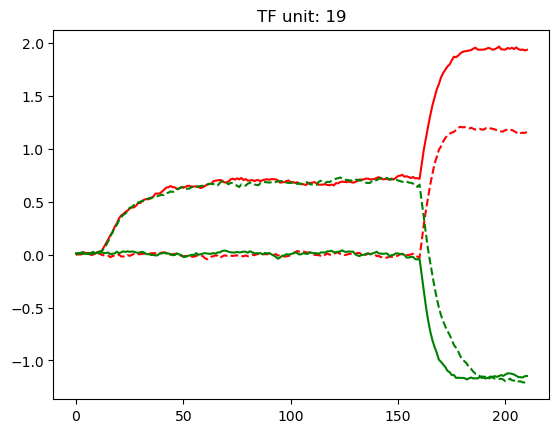

In [71]:
# draw some input units
aaa = [0,1,2,3,4,8,9,10]

for mm in range(0,20):
    n = mm
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

In [ ]:
[0,1,3,4,5,14,15,17,18,19,    2,6,8,9,10,11,13,16]


[20,21,23,27,28,30,33,34,35,36,37,  22,24,25,26,29,31,38,39]

/tmp/ipykernel_121296/1356217798.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


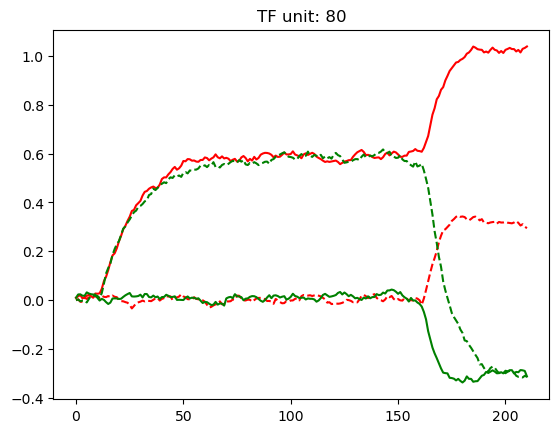

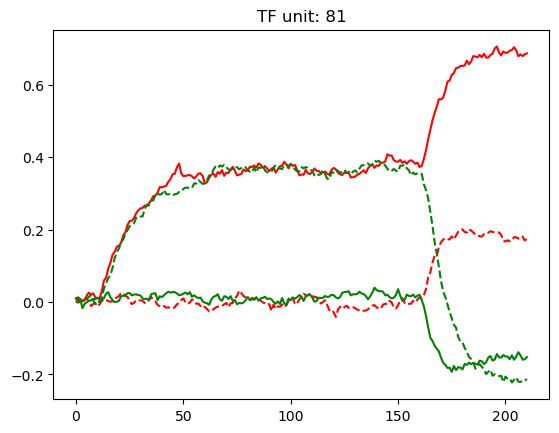

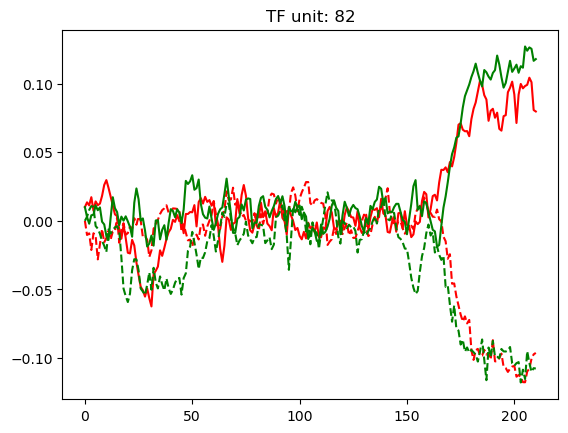

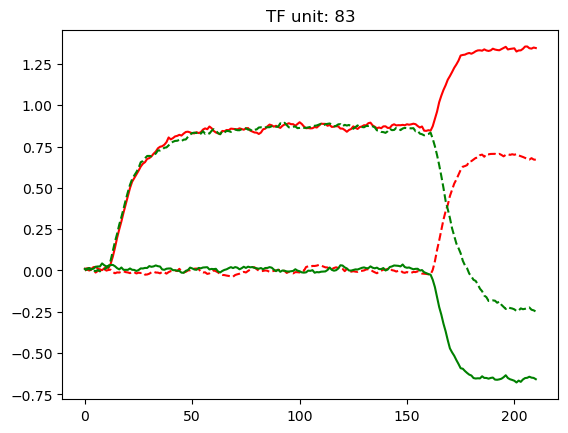

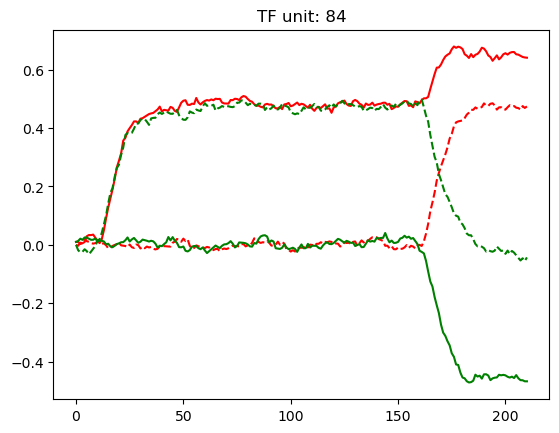

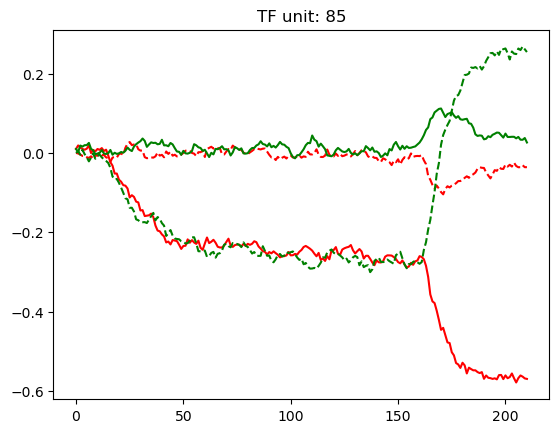

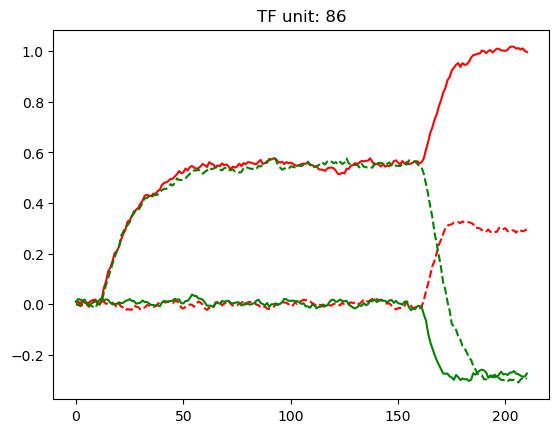

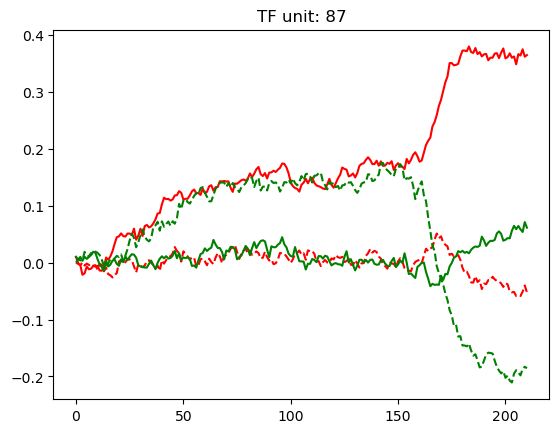

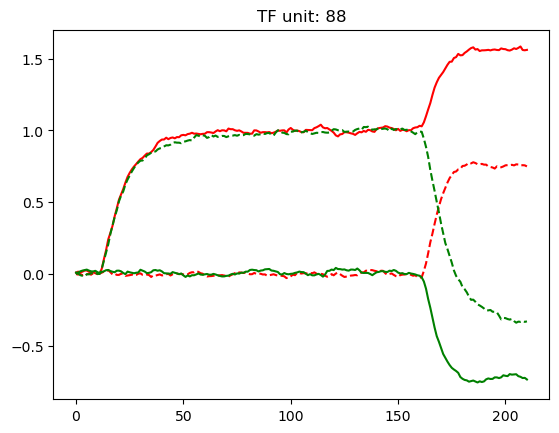

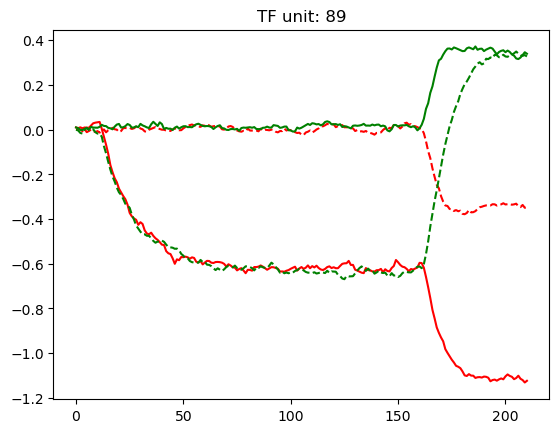

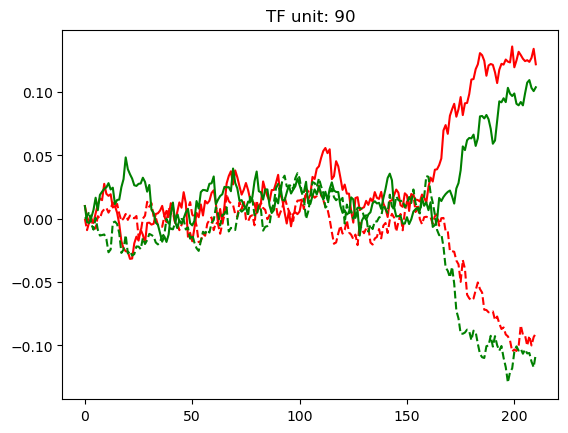

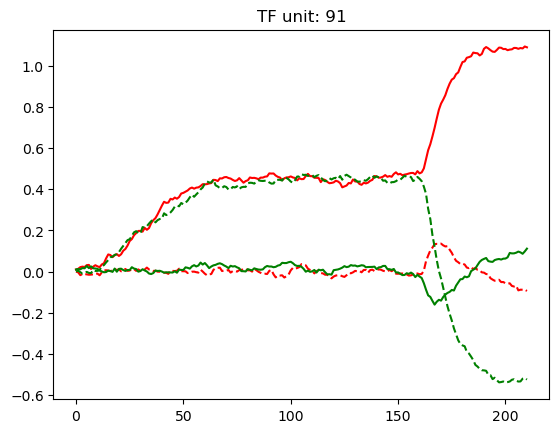

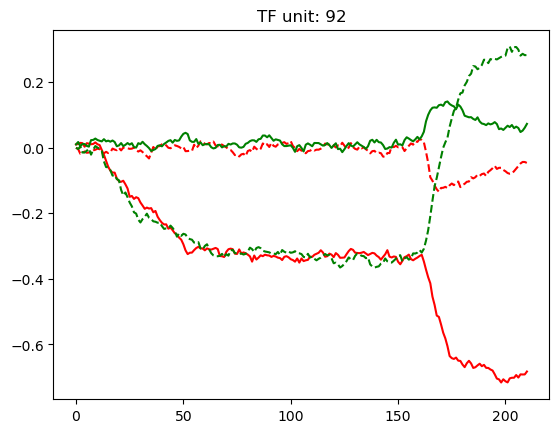

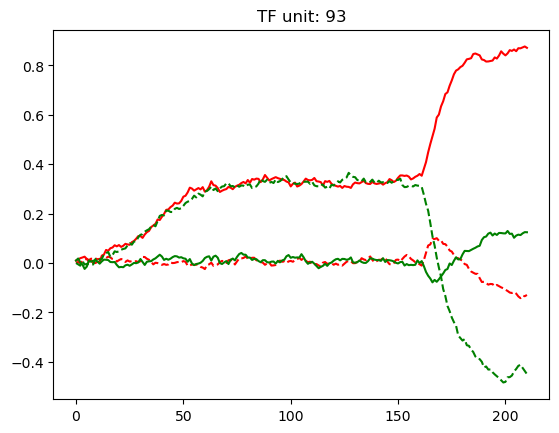

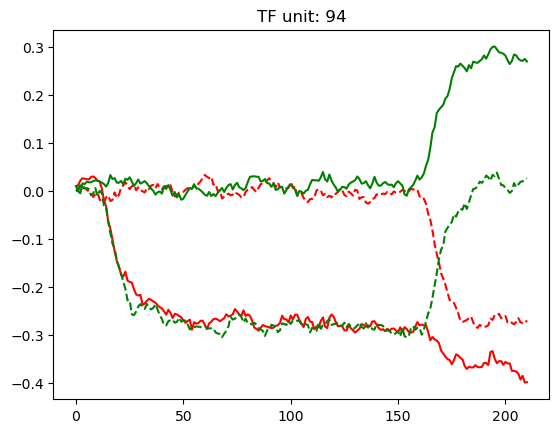

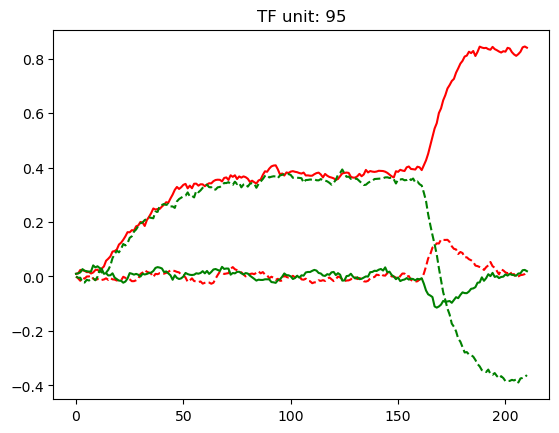

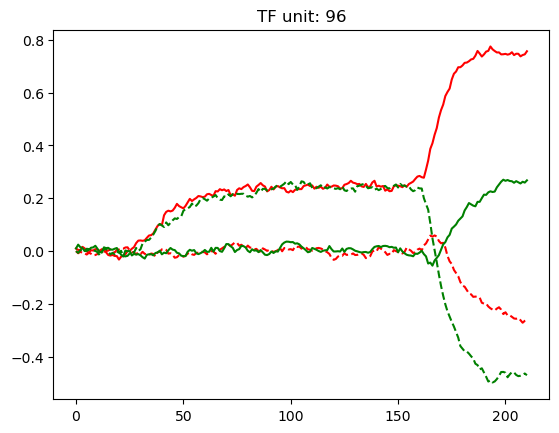

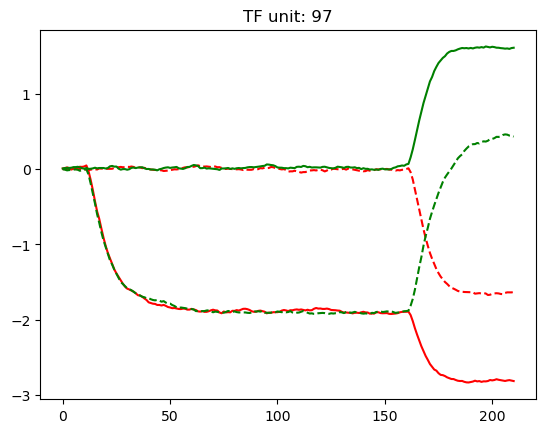

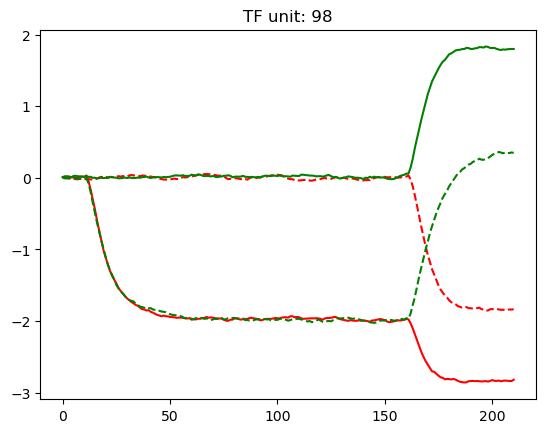

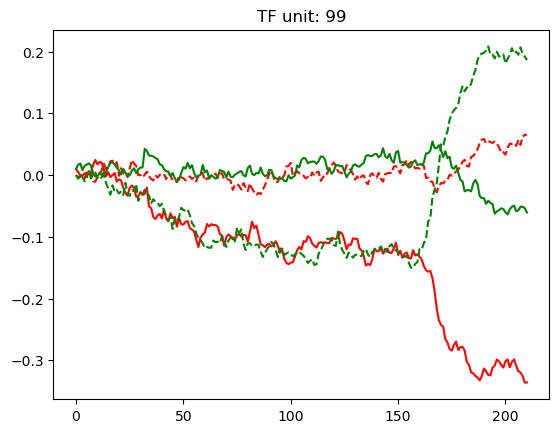

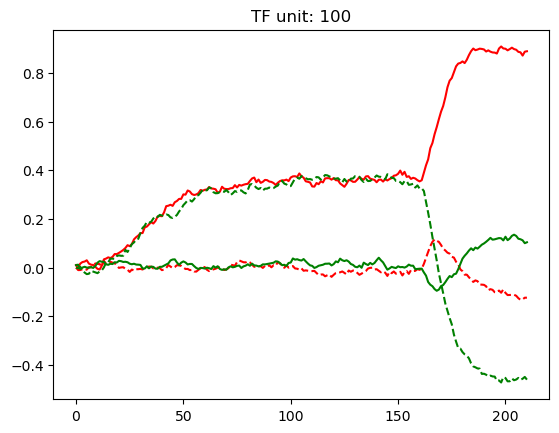

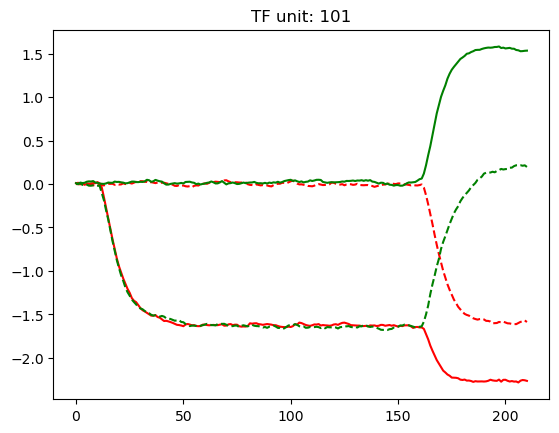

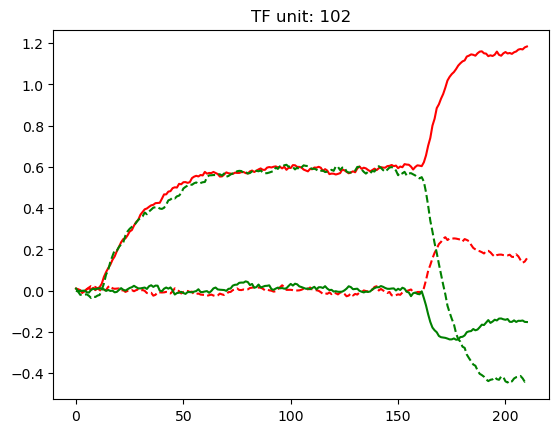

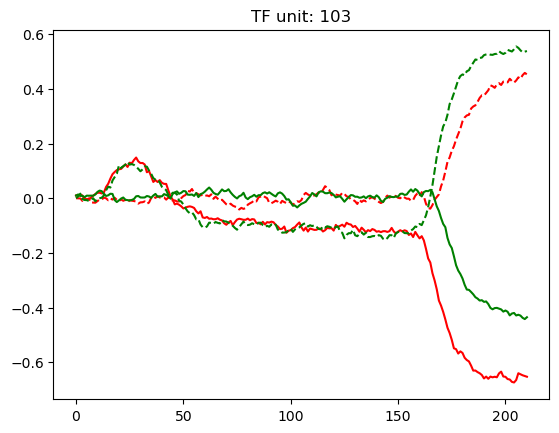

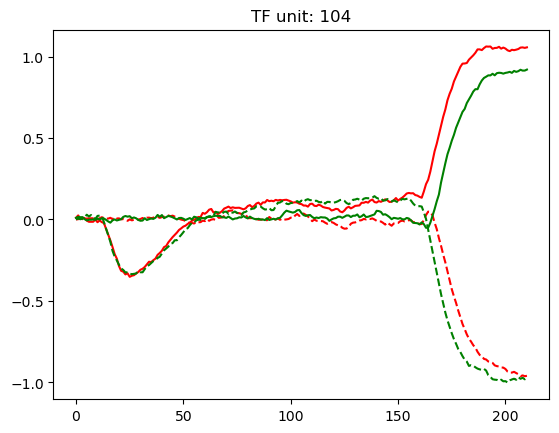

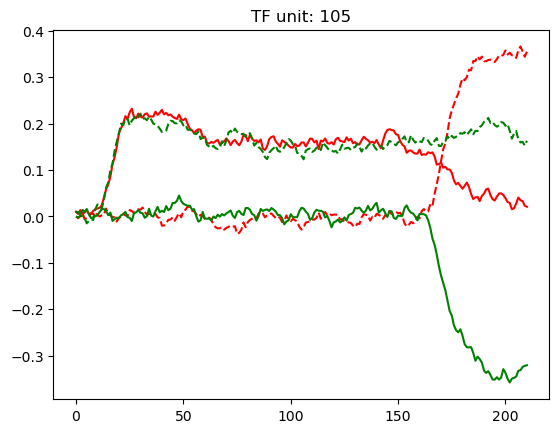

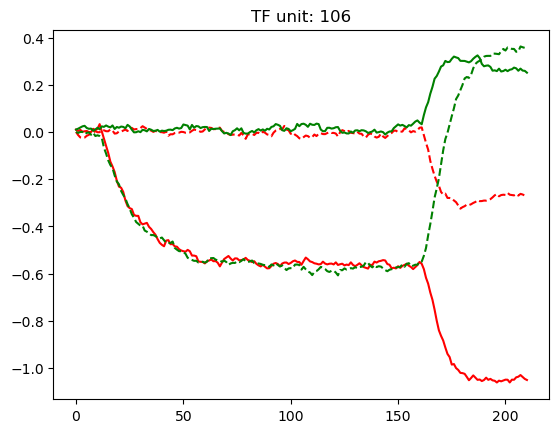

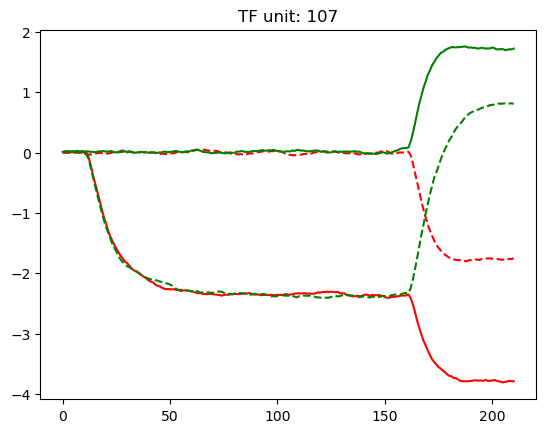

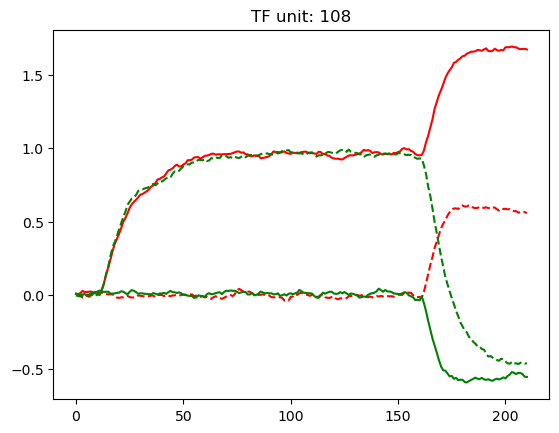

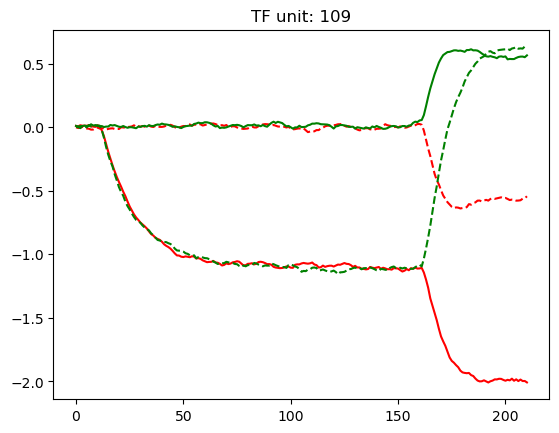

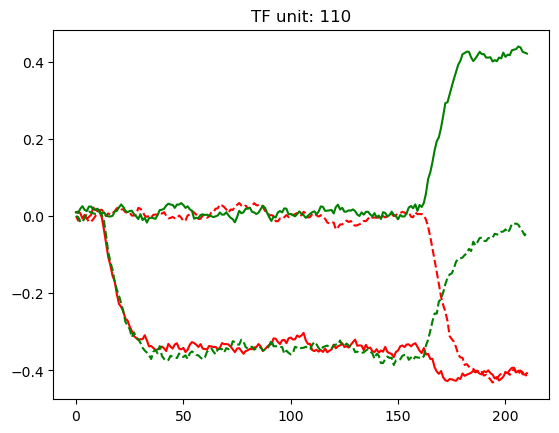

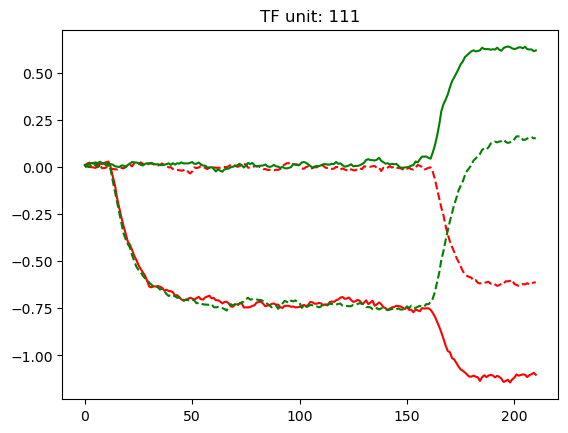

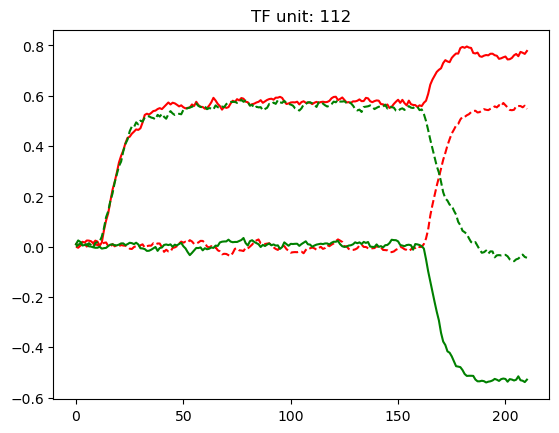

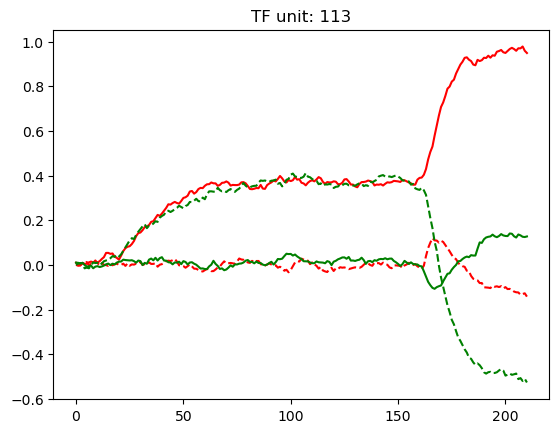

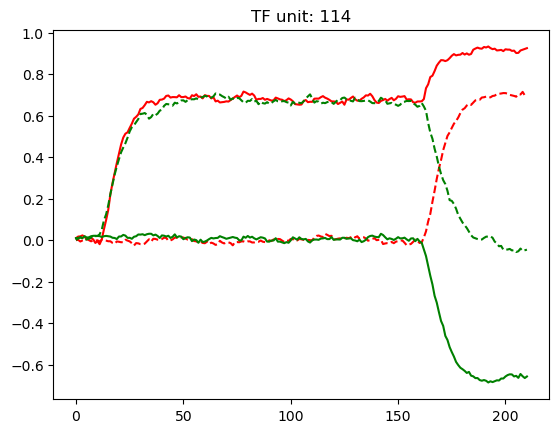

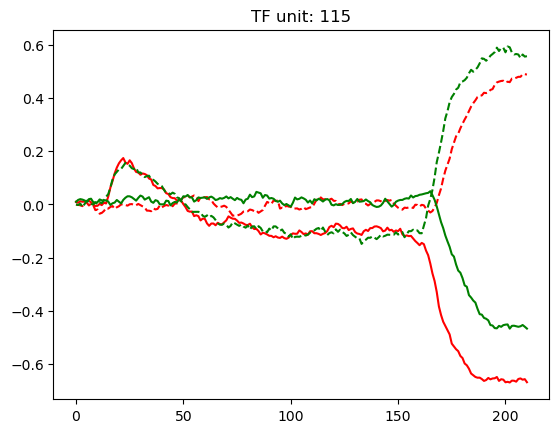

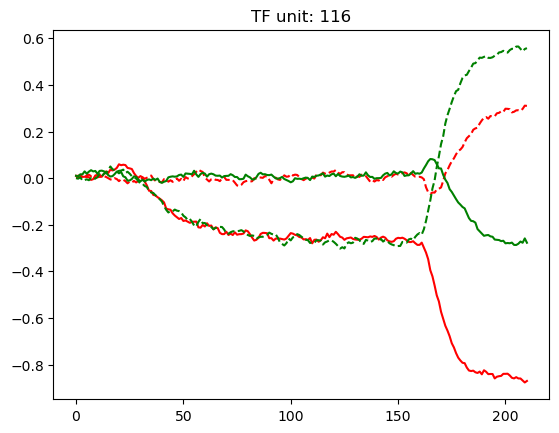

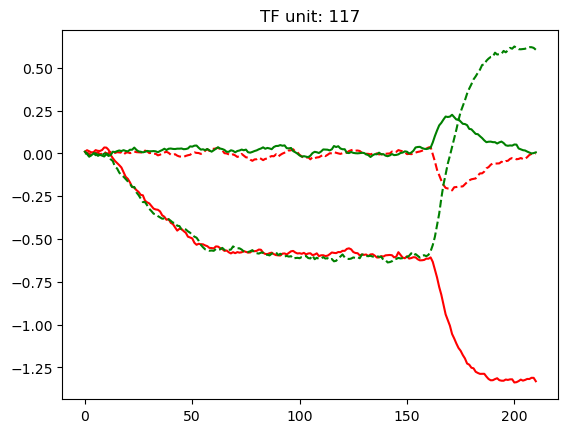

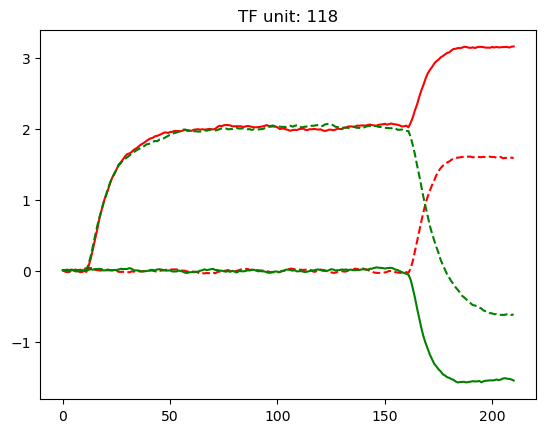

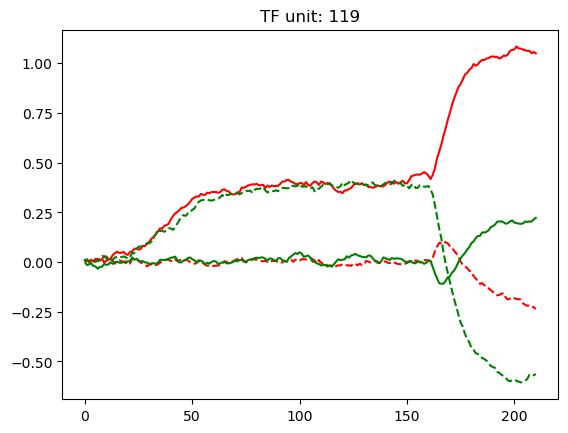

In [63]:
# draw some output units


for mm in range(80,120):
    n = mm
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

In [ ]:


[87,91,93,96,100,104,113,119,   96,103,115,116]

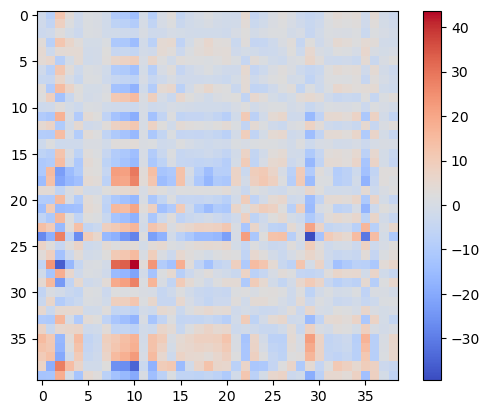

In [58]:
plt.imshow(J[80:120,1:40])
plt.colorbar()
plt.set_cmap('coolwarm')

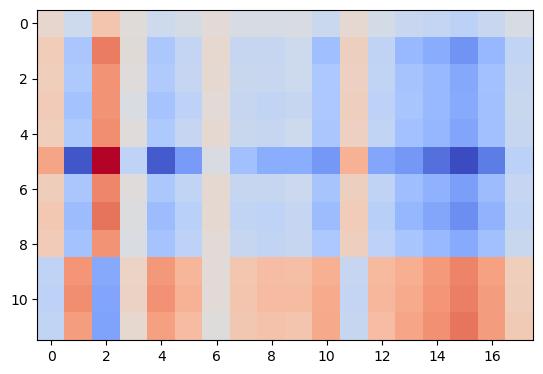

In [75]:
# dir & col
cntTo = [91,92,96,100,104,107,112,114,116,  84,98,102,103,108,110,119]
cntFrom =  [1,3,4,5,6,7,12,13,22,26,  0,2,8,10,11,14,18,20,21,27]

cntTo = [87,91,93,96,100,104,113,119,   96,103,115,116]
cntFrom = [0,1,3,4,5,14,15,17,18,19,    2,6,8,9,10,11,13,16]




Jsub = np.zeros((len(cntTo), len(cntFrom)))

for ii in range(len(cntTo)):
    for jj in range(len(cntFrom)):
        Jsub[ii,jj] = J[cntTo[ii],cntFrom[jj]]
plt.imshow(Jsub)

16

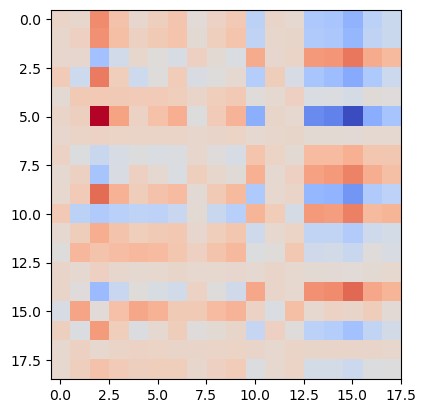

In [74]:
# cxt (output) & col

cntTo = [91,96,100,104,112,114,116,102,110,119,   92,107,84,98,103,108]
cntFrom =  [1,3,4,5,6,7,12,13,22,26,  0,2,8,10,11,14,18,20,21,27]

cntTo = [20,21,23,27,28,30,33,34,35,36,37,  22,24,25,26,29,31,38,39]
cntFrom =  [0,1,3,4,5,14,15,17,18,19,    2,6,8,9,10,11,13,16]





Jsub = np.zeros((len(cntTo), len(cntFrom)))

for ii in range(len(cntTo)):
    for jj in range(len(cntFrom)):
        Jsub[ii,jj] = J[cntTo[ii],cntFrom[jj]]
plt.imshow(Jsub)

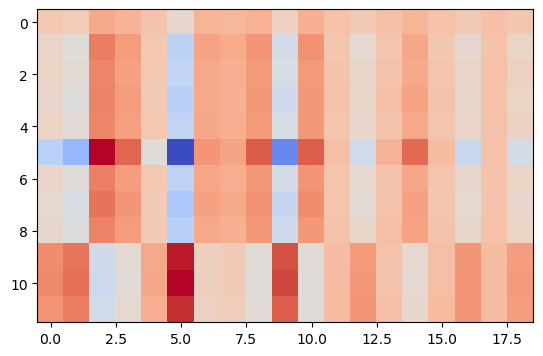

In [76]:
# dir (output) & cxt

cntTo = [91,92,96,100,104,107,112,114,116,  84,98,102,103,108,110,119]
cntFrom =  [1,6,7,22,11,18,21,   3,4,5,12,13,26,0,2,8,10,14,20,27]


cntTo = [87,91,93,96,100,104,113,119,   96,103,115,116]
cntFrom = [20,21,23,27,28,30,33,34,35,36,37,  22,24,25,26,29,31,38,39]

Jsub = np.zeros((len(cntTo), len(cntFrom)))

for ii in range(len(cntTo)):
    for jj in range(len(cntFrom)):
        Jsub[ii,jj] = J[cntTo[ii],cntFrom[jj]]
plt.imshow(Jsub)

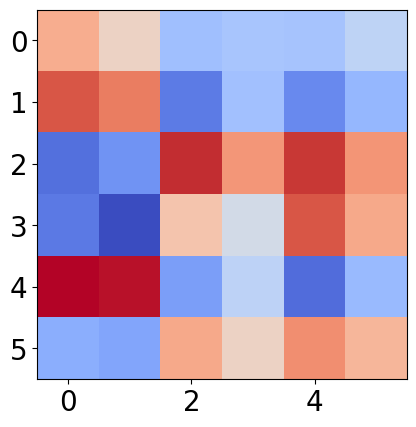

In [124]:
cntTo = [100,114,119,103,107,108]
cntFrom =  [1,4,22,2,10,27]

Jsub = np.zeros((len(cntTo), len(cntFrom)))

for ii in range(len(cntTo)):
    for jj in range(len(cntFrom)):
        Jsub[ii,jj] = J[cntTo[ii],cntFrom[jj]]
plt.imshow(Jsub)

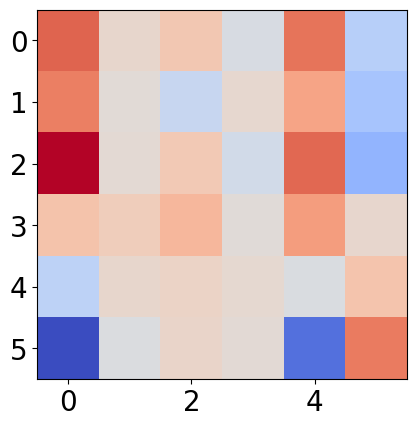

In [125]:
cntTo = [100,107,114,103,108,119]
cntFrom =  [100,114,119,103,107,108]

Jsub = np.zeros((len(cntTo), len(cntFrom)))

for ii in range(len(cntTo)):
    for jj in range(len(cntFrom)):
        Jsub[ii,jj] = J[cntTo[ii],cntFrom[jj]]
plt.imshow(Jsub)